In [1]:
import os
import open3d as o3d
import numpy as np
from plyfile import PlyData, PlyElement
from torch import nn
import torch
from errno import EEXIST
import math
from matplotlib import pyplot as plt
import json
from pathlib import Path
import cv2
from scipy.spatial import KDTree
from utility_m import *
from PIL import Image 

In [6]:
%matplotlib widget

# Util

In [3]:
class GaussianModel:

    def __init__(self, sh_degree : int):
        self.active_sh_degree = 0
        self.max_sh_degree = sh_degree  
        self._xyz = torch.empty(0)
        self._features_dc = torch.empty(0)
        self._features_rest = torch.empty(0)
        self._scaling = torch.empty(0)
        self._rotation = torch.empty(0)
        self._opacity = torch.empty(0)
        self.max_radii2D = torch.empty(0)
        self.xyz_gradient_accum = torch.empty(0)
        self.denom = torch.empty(0)
        self.optimizer = None
        self.percent_dense = 0
        self.spatial_lr_scale = 0
        self.significance_score = torch.empty(0)
        
        self.scaling_activation = torch.exp
        self.opacity_activation = torch.sigmoid
        self.rotation_activation = torch.nn.functional.normalize
        self.covariance_activation = self.build_covariance_from_scaling_rotation

    def save_ply(self, path):

        xyz = self._xyz.detach().cpu().numpy()
        # normals = np.zeros_like(xyz)
        normals = np.zeros_like(xyz)
        f_dc = self._features_dc.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
        f_rest = self._features_rest.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
        opacities = self._opacity.detach().cpu().numpy()
        scale = self._scaling.detach().cpu().numpy()
        rotation = self._rotation.detach().cpu().numpy()

        dtype_full = [(attribute, 'f4') for attribute in self.construct_list_of_attributes()]

        elements = np.empty(xyz.shape[0], dtype=dtype_full)
        attributes = np.concatenate((xyz, normals, f_dc, f_rest, opacities, scale, rotation), axis=1)
        elements[:] = list(map(tuple, attributes))
        el = PlyElement.describe(elements, 'vertex')
        PlyData([el]).write(path)

    def load_ply(self, path):
        plydata = PlyData.read(path)

        xyz = np.stack((np.asarray(plydata.elements[0]["x"]),
                        np.asarray(plydata.elements[0]["y"]),
                        np.asarray(plydata.elements[0]["z"])),  axis=1)
        normals = np.stack((np.asarray(plydata.elements[0]["nx"]),
                            np.asarray(plydata.elements[0]["ny"]),
                            np.asarray(plydata.elements[0]["nz"])),  axis=1)
        opacities = np.asarray(plydata.elements[0]["opacity"])[..., np.newaxis]

        features_dc = np.zeros((xyz.shape[0], 3, 1))
        features_dc[:, 0, 0] = np.asarray(plydata.elements[0]["f_dc_0"])
        features_dc[:, 1, 0] = np.asarray(plydata.elements[0]["f_dc_1"])
        features_dc[:, 2, 0] = np.asarray(plydata.elements[0]["f_dc_2"])

        extra_f_names = [p.name for p in plydata.elements[0].properties if p.name.startswith("f_rest_")]
        extra_f_names = sorted(extra_f_names, key = lambda x: int(x.split('_')[-1]))
        assert len(extra_f_names)==3*(self.max_sh_degree + 1) ** 2 - 3
        features_extra = np.zeros((xyz.shape[0], len(extra_f_names)))
        for idx, attr_name in enumerate(extra_f_names):
            features_extra[:, idx] = np.asarray(plydata.elements[0][attr_name])
        # Reshape (P,F*SH_coeffs) to (P, F, SH_coeffs except DC)
        features_extra = features_extra.reshape((features_extra.shape[0], 3, (self.max_sh_degree + 1) ** 2 - 1))

        scales = self._extracted_from_load_ply_26(plydata, "scale_", xyz)
        rots = self._extracted_from_load_ply_26(plydata, "rot", xyz)
        self._xyz = torch.tensor(xyz, dtype=torch.float, device="cpu")
        self._normal = torch.tensor(normals, dtype=torch.float, device="cpu")
        self._features_dc = torch.tensor(features_dc, dtype=torch.float, device="cpu").transpose(1, 2).contiguous()
        self._features_rest = torch.tensor(features_extra, dtype=torch.float, device="cpu").transpose(1, 2).contiguous()
        self._opacity = torch.tensor(opacities, dtype=torch.float, device="cpu")
        self._scaling = torch.tensor(scales, dtype=torch.float, device="cpu")
        self._rotation = torch.tensor(rots, dtype=torch.float, device="cpu")

        self.active_sh_degree = self.max_sh_degree

    def _extracted_from_load_ply_26(self, plydata, arg1, xyz):
        scale_names = [
            p.name
            for p in plydata.elements[0].properties
            if p.name.startswith(arg1)
        ]
        scale_names = sorted(scale_names, key = lambda x: int(x.split('_')[-1]))
        result = np.zeros((xyz.shape[0], len(scale_names)))
        for idx, attr_name in enumerate(scale_names):
            result[:, idx] = np.asarray(plydata.elements[0][attr_name])

        return result

    def construct_list_of_attributes(self):
        l = ['x', 'y', 'z', 'nx', 'ny', 'nz']
        # All channels except the 3 DC
        l.extend(
            f'f_dc_{i}'
            for i in range(self._features_dc.shape[1] * self._features_dc.shape[2])
        )
        l.extend(
            f'f_rest_{i}'
            for i in range(
                self._features_rest.shape[1] * self._features_rest.shape[2]
            )
        )
        l.append('opacity')
        l.extend(f'scale_{i}' for i in range(self._scaling.shape[1]))
        l.extend(f'rot_{i}' for i in range(self._rotation.shape[1]))
        return l
    

    def build_rotation(self, r):
        norm = torch.sqrt(r[:,0]*r[:,0] + r[:,1]*r[:,1] + r[:,2]*r[:,2] + r[:,3]*r[:,3])

        q = r / norm[:, None]

        R = torch.zeros((q.size(0), 3, 3), device='cpu')

        r = q[:, 0]
        x = q[:, 1]
        y = q[:, 2]
        z = q[:, 3]

        R[:, 0, 0] = 1 - 2 * (y*y + z*z)
        R[:, 0, 1] = 2 * (x*y - r*z)
        R[:, 0, 2] = 2 * (x*z + r*y)
        R[:, 1, 0] = 2 * (x*y + r*z)
        R[:, 1, 1] = 1 - 2 * (x*x + z*z)
        R[:, 1, 2] = 2 * (y*z - r*x)
        R[:, 2, 0] = 2 * (x*z - r*y)
        R[:, 2, 1] = 2 * (y*z + r*x)
        R[:, 2, 2] = 1 - 2 * (x*x + y*y)
        return R
    
    def build_scaling_rotation(self, s, r):
        L = torch.zeros((s.shape[0], 3, 3), dtype=torch.float, device="cpu")
        R = self.build_rotation(r)

        L[:,0,0] = s[:,0]
        L[:,1,1] = s[:,1]
        L[:,2,2] = s[:,2]

        L = R @ L
        return L
    
    def strip_lowerdiag(self, L):
        uncertainty = torch.zeros((L.shape[0], 6), dtype=torch.float, device="cpu")

        uncertainty[:, 0] = L[:, 0, 0]
        uncertainty[:, 1] = L[:, 0, 1]
        uncertainty[:, 2] = L[:, 0, 2]
        uncertainty[:, 3] = L[:, 1, 1]
        uncertainty[:, 4] = L[:, 1, 2]
        uncertainty[:, 5] = L[:, 2, 2]
        return uncertainty

    def strip_symmetric(self, sym):
        return self.strip_lowerdiag(sym)
    
    def build_covariance_from_scaling_rotation(self, scaling, scaling_modifier, rotation):
        L = self.build_scaling_rotation(scaling_modifier * scaling, rotation)
        actual_covariance = L @ L.transpose(1, 2)
        symm = self.strip_symmetric(actual_covariance)
        return symm
    
    @property
    def get_scaling(self):
        return self.scaling_activation(self._scaling)
    
    @property
    def get_opacity(self):
        return self.opacity_activation(self._opacity)
    
    @property
    def get_rotation(self):
        return self.rotation_activation(self._rotation)
    
    @property
    def get_xyz(self):
        return self._xyz
    
    @property
    def get_features(self):
        features_dc = self._features_dc
        features_rest = self._features_rest
        return torch.cat((features_dc, features_rest), dim=1)

    def get_covariance(self, scaling_modifier = 1):
        return self.covariance_activation(self.get_scaling, scaling_modifier, self._rotation)


# Working on a dataset "The VR-NeRF Eyeful Tower Dataset". 

- https://github.com/facebookresearch/EyefulTower?tab=readme-ov-file
- This dataset is originally used for NeRF. 

In [8]:
'''
1. Move all the images from different cameras into the same file
2. Downsample the number of dataset
2. Convert all the images to executable format for 3DGS
'''

dataset_dir = "/home/yuang/Desktop/3d_gaussian_splat/dataset/source/eyefultower/apartment/images-jpeg-2k"
input_dir = "/home/yuang/Desktop/3d_gaussian_splat/dataset/source/eyefultower/apartment/input"

In [9]:
# # for each dir in dataset_dir, move all files with extension .jpg in the dir to input_dir
# for dir in os.listdir(dataset_dir):
#     if os.path.isdir(os.path.join(dataset_dir, dir)):
#         for file in os.listdir(os.path.join(dataset_dir, dir)):
#             if file.endswith(".jpg"):
#                 os.rename(os.path.join(dataset_dir, dir, file), os.path.join(input_dir, file))
#                 print(f"move {file} to {input_dir}")

In [10]:
# uniformly select n images from the input_dir over all the images, not randomly
n = 1750
selected_files = []
input_files = os.listdir(input_dir)
input_files.sort()
# selected_files = input_files[::math.ceil((len(input_files)/n))]
interval = len(input_files) / n
index = 0
while len(selected_files) < n and index < len(input_files):
    selected_files.append(input_files[int(index)])
    index += interval


# **copy** the selected images to a new dir
output_dir = f"/home/yuang/Desktop/3d_gaussian_splat/dataset/source/eyefultower/apartment_{n}/input"
try:
    os.makedirs(output_dir)
except OSError as e:
    if e.errno != EEXIST:
        raise
for file in selected_files:
    os.system(f"cp {os.path.join(input_dir, file)} {output_dir}")
    print(f"copy {file} to {output_dir}")


FileNotFoundError: [Errno 2] No such file or directory: '/home/yuang/Desktop/3d_gaussian_splat/dataset/source/eyefultower/apartment/input'

In [ ]:
# convert the images to executable format
# python convert.py -s {the parent dir of input_dir}
# os.system(f"python convert.py -s {os.path.dirname(input_dir)}")

## Converts EyefulTower cameras.json format to Nerfstudio's transforms.json format

In [ ]:
import collections


def convert_cameras_to_nerfstudio_transforms(
    cameras: dict, splits: dict, target_width: int, target_height: int, extension: str
) -> dict:
    """Converts EyefulTower cameras.json format to Nerfstudio's transforms.json format

    The EyefulTower dataset provides a cameras.json file containing geometric calibration information for the
    original resolution ~8K images, similar to the cameras.xml file from Metashape. The main advantage is that data
    is provided for each individual image, rather than being structured hierarchically with rig constraints (as in
    the Metashape cameras.xml).

    This function takes the cameras.json file and converts it to the transforms.json Nerfstudio expects, with the
    necessary scaling of intrinsics parameters applied. This function also handles the EyefulTower splits.json file,
    describing the breakdown of training and validation images, and adds the appropriate fields to transforms.json.
    This function works for both fisheye (V1) and pinhole (V2) cameras. Scene-specific fisheye mask radii are added
    to the returned dictionary if needed.

    Args:
        capture_name: Which specific EyefulTower capture is being converted
        cameras: Data loaded from EyefulTower cameras.json
        splits: Data loaded from EyefulTower splits.json
        target_width: Width of output images
        target_height: Height of output images
        extension: Extension of output images

    Returns:
        Dict in the Nerfstudio transforms.json format, with scaled camera parameters, splits, and optional metadata.
    """
    output = {}

    distortion_models = [c["distortionModel"] for c in cameras["KRT"]]
    distortion_model = list(set(distortion_models))
    assert len(distortion_model) == 1
    distortion_model = distortion_model[0]
    if distortion_model == "RadialAndTangential":
        output["camera_model"] = "OPENCV"
    else:
        raise NotImplementedError(f"Camera model {distortion_model} not implemented")

    split_sets = {k: set(v) for k, v in splits.items()}

    frames = []
    split_filenames = collections.defaultdict(list)
    for camera in cameras["KRT"]:
        frame = {"file_path": camera["cameraId"] + f".{extension}"}
        for split in split_sets:
            if camera["cameraId"] in split_sets[split]:
                split_filenames[split].append(frame["file_path"])

        original_width = camera["width"]
        original_height = camera["height"]
        if original_width > original_height:
            target_width, target_height = max(target_width, target_height), min(target_width, target_height)
        else:
            target_height, target_width = max(target_width, target_height), min(target_width, target_height)
        x_scale = target_width / original_width
        y_scale = target_height / original_height

        frame["w"] = target_width
        frame["h"] = target_height
        K = np.array(camera["K"]).T  # Data stored as column-major
        frame["fl_x"] = K[0][0] * x_scale
        frame["fl_y"] = K[1][1] * y_scale
        frame["cx"] = K[0][2] * x_scale
        frame["cy"] = K[1][2] * y_scale

        if distortion_model == "Fisheye":
            # fisheye: [k1, k2, k3, _, _, _, p1, p2]
            frame["k1"] = camera["distortion"][0]
            frame["k2"] = camera["distortion"][1]
            frame["k3"] = camera["distortion"][2]
            frame["p1"] = camera["distortion"][6]
            frame["p2"] = camera["distortion"][7]
        elif distortion_model == "RadialAndTangential":
            # pinhole: [k1, k2, p1, p2, k3]
            frame["k1"] = camera["distortion"][0]
            frame["k2"] = camera["distortion"][1]
            frame["k3"] = camera["distortion"][4]
            frame["k4"] = 0.0
            frame["p1"] = camera["distortion"][2]
            frame["p2"] = camera["distortion"][3]
        else:
            raise NotImplementedError("This shouldn't happen")

        T = np.array(camera["T"]).T  # Data stored as column-major
        T = np.linalg.inv(T)
        T = T[[2, 0, 1, 3], :]
        T[:, 1:3] *= -1
        frame["transform_matrix"] = T.tolist()

        frames.append(frame)

    frames = sorted(frames, key=lambda f: f["file_path"])

    output["frames"] = frames
    output["train_filenames"] = split_filenames["train"]
    output["val_filenames"] = split_filenames["test"]
    output["test_filenames"] = []
    return output

In [ ]:
@dataclass
class EyefulTowerResolutionMetadata:
    folder_name: str
    width: int
    height: int
    extension: str


eyefultower_resolutions = {
    "all": None,
    "jpeg_1k": EyefulTowerResolutionMetadata("images-jpeg-1k", 684, 1024, "jpg"),
    "jpeg_2k": EyefulTowerResolutionMetadata("images-jpeg-2k", 1368, 2048, "jpg"),
    "jpeg_4k": EyefulTowerResolutionMetadata("images-jpeg-4k", 2736, 4096, "jpg"),
    "jpeg_8k": EyefulTowerResolutionMetadata("images-jpeg", 5784, 8660, "jpg"),
    "exr_1k": EyefulTowerResolutionMetadata("images-1k", 684, 1024, "exr"),
    "exr_2k": EyefulTowerResolutionMetadata("images-2k", 1368, 2048, "exr"),
}

json_input_path = "/Volumes/Research/3dgs-dataset/apartment/cameras.json"
splits_input_path = "/Volumes/Research/3dgs-dataset/apartment/splits.json"
json_output_path = "/Volumes/Research/3dgs-dataset/apartment/transforms.json"

with open(json_input_path, "r") as f:
    cameras = json.load(f)
    
with open(splits_input_path, "r") as f:
    splits = json.load(f)


metadata = eyefultower_resolutions["jpeg_1k"]

cameras = cameras
splits = splits
target_width = metadata.width
target_height = metadata.height
extension = metadata.extension

In [ ]:
transforms = convert_cameras_to_nerfstudio_transforms(
    cameras, splits, target_width, target_height, extension
)

with open(json_output_path, "w", encoding="utf8") as f:
                        json.dump(transforms, f, indent=4)

In [ ]:
with open(json_output_path, "r", encoding="utf8") as f:
    transforms = json.load(f)

# output the frames whose names are shown in train_filenames into transforms_train.json
train_json_output_path = "/Volumes/Research/3dgs-dataset/apartment/transforms_train.json"
train_frames = [
    frame
    for frame in transforms["frames"]
    if frame["file_path"] in transforms["train_filenames"]
]
output = {"camera_model": "OPENCV", "frames": train_frames}
with open(train_json_output_path, "w", encoding="utf8") as f:
    json.dump(output, f, indent=4)

# output the frames whose names are shown in val_filenames into transforms_test.json
test_json_output_path = "/Volumes/Research/3dgs-dataset/apartment/transforms_test.json"
test_frames = [
    frame
    for frame in transforms["frames"]
    if frame["file_path"] in transforms["val_filenames"]
]
output = {"camera_model": "OPENCV", "frames": test_frames}
with open(test_json_output_path, "w", encoding="utf8") as f:
    json.dump(output, f, indent=4)


# Data distribution of 3DGS

## 3DGS distribution

In [ ]:
gs = GaussianModel(3)
gs.load_ply("/Users/yuangshi/Documents/PhD/3DGS/quantization/drjohnson.ply")

In [ ]:
gs._xyz.shape, gs._features_dc.shape, gs._features_rest.shape, gs._opacity.shape, gs._scaling.shape, gs._rotation.shape

(torch.Size([3405153, 3]),
 torch.Size([3405153, 1, 3]),
 torch.Size([3405153, 15, 3]),
 torch.Size([3405153, 1]),
 torch.Size([3405153, 3]),
 torch.Size([3405153, 4]))

In [ ]:
position = gs._xyz
features_dc = gs._features_dc
features_rest = gs._features_rest
opacity = gs._opacity
scaling = gs._scaling
rotation = gs._rotation


In [ ]:
x = position[:, 0]
y = position[:, 1]
z = position[:, 2]


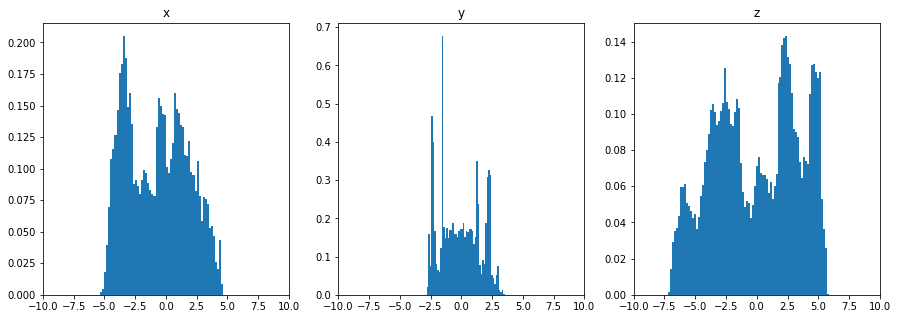

In [ ]:
# get the CDF of x, y, z separately

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(x, bins=100, density=True)
axs[0].set_xlim(-10, 10)
axs[0].set_title('x')
axs[1].hist(y, bins=100, density=True)
axs[1].set_title('y')
axs[1].set_xlim(-10, 10)
axs[2].hist(z, bins=100, density=True)
axs[2].set_title('z')
axs[2].set_xlim(-10, 10)
plt.show()


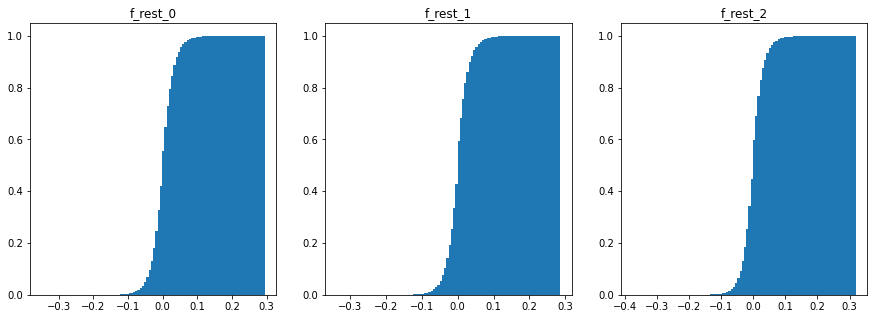

In [ ]:
# get the histograms to plot the distribution of feature_rest

f_rest = features_rest.flatten(start_dim=1).contiguous()
f_rest = f_rest.detach().cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(f_rest[:, 0], bins=100, cumulative=True, density=True)
axs[0].set_title('f_rest_0')
axs[1].hist(f_rest[:, 1], bins=100, cumulative=True, density=True)
axs[1].set_title('f_rest_1')
axs[2].hist(f_rest[:, 2], bins=100, cumulative=True, density=True)
axs[2].set_title('f_rest_2')
plt.show()



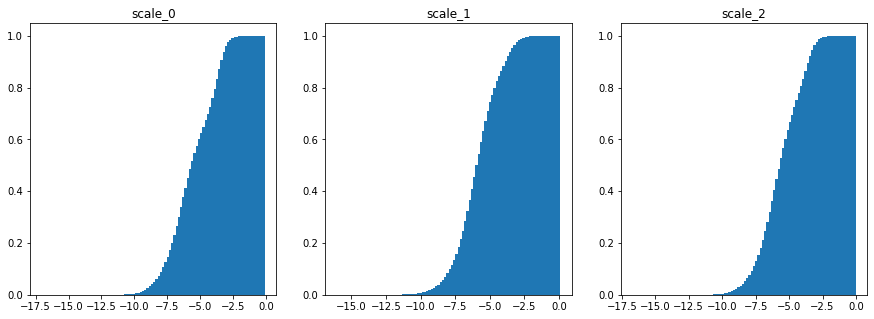

In [ ]:
# get the histograms to plot the distribution of scale

scales = scaling.detach().cpu().numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].hist(scales[:, 0], bins=100, cumulative=True, density=True)
axs[0].set_title('scale_0')
axs[1].hist(scales[:, 1], bins=100, cumulative=True, density=True)
axs[1].set_title('scale_1')
axs[2].hist(scales[:, 2], bins=100, cumulative=True, density=True)
axs[2].set_title('scale_2')
plt.show()


## Camera distribution

In [ ]:
camera_json = "/Users/yuangshi/Documents/PhD/3DGS/cameras_3000_colmap.json"
with open(camera_json) as f:
    cameras = json.load(f)

camera_positions = [camera['position'] for camera in cameras]

In [ ]:
# store the camera positions into point cloud
camera_positions = np.array(camera_positions)
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(camera_positions)
# save the point cloud
o3d.io.write_point_cloud("/Users/yuangshi/Documents/PhD/3DGS/camera_positions.ply", pcd)

# o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


# Using quantization to make distorted 3DGS

- Perform quantization on bit depth to make distorted 3DGS.

In [ ]:

def quantize_array(arr, bit_depth):
    # Calculate the maximum value based on the desired bit depth
    max_value = (2 ** bit_depth) - 1

    return np.round(arr * max_value) / max_value

In [ ]:
# we group the features into three groups: 
    # 1. position: xyz, 
    # 2. color: normal, features_dc, features_rest, opacity
    # 3. size: scaling, rotation

path = "/home/yuang/Desktop/3d_gaussian_splat/dataset/pre-trained_model/drjohnson/point_cloud/iteration_30000/point_cloud.ply"
max_sh_degree = 3

gm = GaussianModel(max_sh_degree)
gm.load_ply(path)

# quantize the features in each group separately, and save the quantized features to a ply file
bit_depth = 4
quantized_xyz = quantize_array(gm._xyz.detach().cpu().numpy(), bit_depth)
quantized_normal = quantize_array(gm._normal.detach().cpu().numpy(), bit_depth)
quantized_features_dc = quantize_array(gm._features_dc.detach().cpu().numpy(), bit_depth)
quantized_features_rest = quantize_array(gm._features_rest.detach().cpu().numpy(), bit_depth)
quantized_opacity = quantize_array(gm._opacity.detach().cpu().numpy(), bit_depth)
quantized_scaling = quantize_array(gm._scaling.detach().cpu().numpy(), bit_depth)
quantized_rotation = quantize_array(gm._rotation.detach().cpu().numpy(), bit_depth)

# save the quantized features to a ply file
quantize_group_list = ["position", "color", "size"]
for group in quantize_group_list:
    if group == "position":
        print("quantize position")
        gm.load_ply(path)
        gm._xyz = nn.Parameter(torch.tensor(quantized_xyz, dtype=torch.float, device="cpu"))
        gm.save_ply(f"/home/yuang/Desktop/3d_gaussian_splat/dataset/pre-trained_model/drjohnson/point_cloud/iteration_30000/point_cloud_{group}_quantized.ply")
    elif group == "color":
        print("quantize color")
        gm.load_ply(path)
        gm._normal = nn.Parameter(torch.tensor(quantized_normal, dtype=torch.float, device="cpu"))
        gm._features_dc = nn.Parameter(torch.tensor(quantized_features_dc, dtype=torch.float, device="cpu"))
        gm._features_rest = nn.Parameter(torch.tensor(quantized_features_rest, dtype=torch.float, device="cpu"))
        gm._opacity = nn.Parameter(torch.tensor(quantized_opacity, dtype=torch.float, device="cpu"))
        gm.save_ply(f"/home/yuang/Desktop/3d_gaussian_splat/dataset/pre-trained_model/drjohnson/point_cloud/iteration_30000/point_cloud_{group}_quantized.ply")
    elif group == "size":
        print("quantize size")
        gm.load_ply(path)
        gm._scaling = nn.Parameter(torch.tensor(quantized_scaling, dtype=torch.float, device="cpu"))
        gm._rotation = nn.Parameter(torch.tensor(quantized_rotation, dtype=torch.float, device="cpu"))
        gm.save_ply(f"/home/yuang/Desktop/3d_gaussian_splat/dataset/pre-trained_model/drjohnson/point_cloud/iteration_30000/point_cloud_{group}_quantized.ply")

# Relation between dataset size and quality

In [ ]:
root = "/Volumes/Research/3dgs-dataset/apartment"

dataset_size_list = [200, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250]
size_quality_dict = {}

for size in dataset_size_list:
    size_quality_dict[size] = {}
    input_dir = f"{root}/subset_{size}/per_view.json"
    results = json.load(open(input_dir))
    # read the SSIM, PSNR, LPIPS from the results
    for key in results.keys():
        for metric in results[key].keys():
            size_quality_dict[size][metric] = []
            for png in results[key][metric].keys():
                eva_value = results[key][metric][png]
                size_quality_dict[size][metric].append(eva_value)
size_quality_dict

{200: {'SSIM': [0.8480948805809021,
   0.8756288290023804,
   0.9048101305961609,
   0.9316938519477844,
   0.9201254844665527,
   0.9433057904243469,
   0.9100098013877869,
   0.917456328868866,
   0.8461963534355164,
   0.8990298509597778,
   0.8999348282814026,
   0.9178481101989746,
   0.8812767267227173,
   0.8589499592781067,
   0.9191498756408691,
   0.8791859745979309,
   0.943172812461853,
   0.9330657124519348,
   0.9004277586936951,
   0.9381030797958374,
   0.9378057718276978,
   0.8608532547950745,
   0.8772221803665161,
   0.8811655640602112,
   0.9190126061439514,
   0.8875206112861633,
   0.9413645267486572,
   0.9012928605079651,
   0.9207757115364075,
   0.9438386559486389,
   0.9136399626731873,
   0.8581712245941162,
   0.9123445749282837,
   0.8754790425300598,
   0.9331868290901184,
   0.9200870394706726,
   0.8833127021789551,
   0.921973466873169,
   0.8859053254127502,
   0.9193122386932373,
   0.9098911881446838,
   0.8378034830093384,
   0.8947083353996277,
 

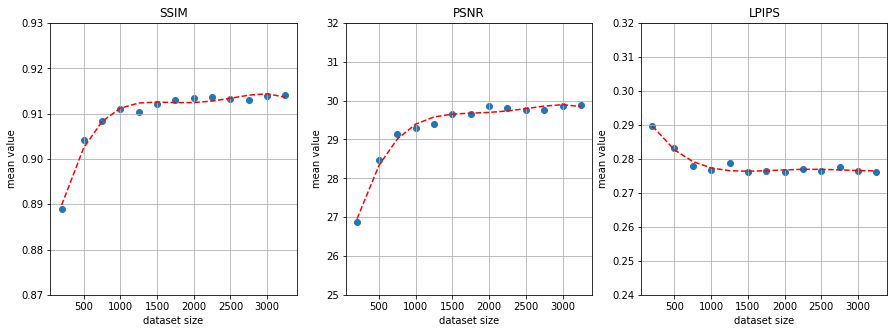

In [ ]:
# plot the mean SSIM, PSNR, LPIPS against the dataset size
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for metric, ax in zip(size_quality_dict[dataset_size_list[0]].keys(), axs):
    ax.scatter(dataset_size_list, [np.mean(size_quality_dict[size][metric]) for size in dataset_size_list], marker='o')
    ax.set_title(metric)
    ax.set_xlabel("dataset size")
    ax.set_ylabel("mean value")
    ax.grid()
    if metric == "SSIM":
        ax.set_ylim(0.87, 0.93)
    elif metric == "PSNR":
        ax.set_ylim(25, 32)
    elif metric == "LPIPS":
        ax.set_ylim(0.24, 0.32)
    
    
    # plot a fitted line based on the points, using polyfit with degree 2
    x = np.array(dataset_size_list)
    y = np.array([np.mean(size_quality_dict[size][metric]) for size in dataset_size_list])
    z = np.polyfit(x, y, 4)
    p = np.poly1d(z)
    ax.plot(x, p(x), "r--")

    
plt.show()

In [ ]:
np.mean(size_quality_dict[1000]["SSIM"]), np.mean(size_quality_dict[1000]["PSNR"]), np.mean(size_quality_dict[1000]["LPIPS"])
# np.mean(size_quality_dict[200]["SSIM"]), np.mean(size_quality_dict[200]["PSNR"]), np.mean(size_quality_dict[200]["LPIPS"])

(0.9111075070312897, 29.29347253207788, 0.27669457005187387)

In [ ]:
np.std(size_quality_dict[1000]["SSIM"]), np.std(size_quality_dict[1000]["PSNR"]), np.std(size_quality_dict[1000]["LPIPS"])

(0.04146034839269542, 4.100410089077829, 0.037879408871627905)

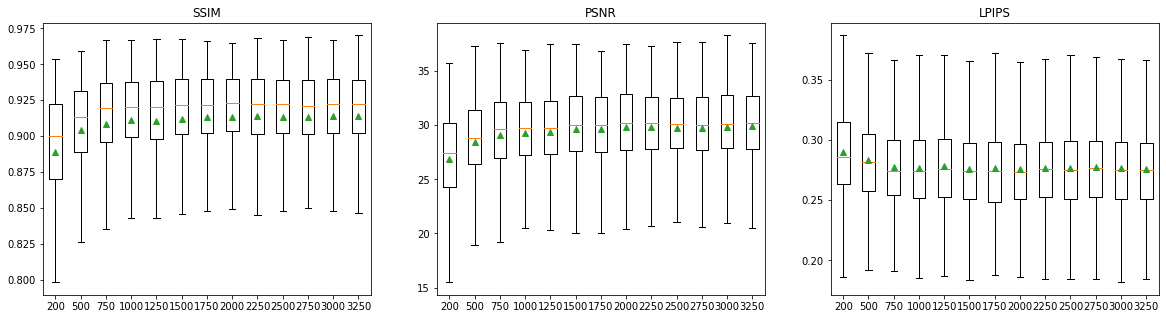

In [ ]:
# plot the SSIM, PSNR, LPIPS against the dataset size
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

dataset_size_list = list(size_quality_dict.keys())
ssim_list = [np.array(value['SSIM']).mean() for value in size_quality_dict.values()]
psnr_list = [np.array(value['PSNR']).mean() for value in size_quality_dict.values()]
lpips_list = [np.array(value['LPIPS']).mean() for value in size_quality_dict.values()]

# axs[0].plot(dataset_size_list, ssim_list, marker='o')
axs[0].boxplot([np.array(value['SSIM']) for value in size_quality_dict.values()], labels=dataset_size_list, showmeans=True, showfliers=False)
axs[0].set_title('SSIM')
# axs[0].set_ylim(0.87, 0.93)

# axs[1].plot(dataset_size_list, psnr_list, marker='o')
axs[1].boxplot([np.array(value['PSNR']) for value in size_quality_dict.values()], labels=dataset_size_list, showmeans=True, showfliers=False)
axs[1].set_title('PSNR')
# axs[1].set_ylim(25, 32)

# axs[2].plot(dataset_size_list, lpips_list, marker='o')
axs[2].boxplot([np.array(value['LPIPS']) for value in size_quality_dict.values()], labels=dataset_size_list, showmeans=True, showfliers=False)
axs[2].set_title('LPIPS')
# axs[2].set_xlim(0, 1450)
# axs[2].set_ylim(0.24, 0.32)


plt.show()

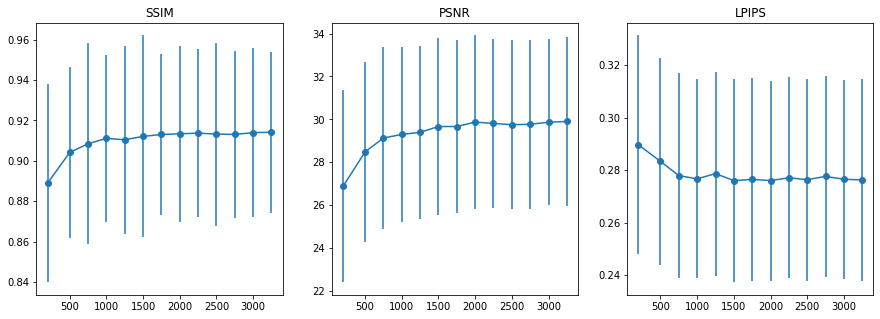

In [ ]:
# plot the SSIM, PSNR, LPIPS against the dataset size
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

dataset_size_list = size_quality_dict.keys()
ssim_list = [np.array(value['SSIM']).mean() for value in size_quality_dict.values()]
psnr_list = [np.array(value['PSNR']).mean() for value in size_quality_dict.values()]
lpips_list = [np.array(value['LPIPS']).mean() for value in size_quality_dict.values()]

axs[0].errorbar(dataset_size_list, ssim_list, yerr=[np.array(value['SSIM']).std() for value in size_quality_dict.values()], fmt='o-')
axs[0].set_title('SSIM')
# axs[0].set_ylim(0.85, 0.93)

axs[1].errorbar(dataset_size_list, psnr_list, yerr=[np.array(value['PSNR']).std() for value in size_quality_dict.values()], fmt='o-')
axs[1].set_title('PSNR')
# axs[1].set_ylim(27, 30.5)

axs[2].errorbar(dataset_size_list, lpips_list, yerr=[np.array(value['LPIPS']).std() for value in size_quality_dict.values()], fmt='o-')
axs[2].set_title('LPIPS')
# axs[2].set_ylim(0.25, 0.35)


plt.show()

In [ ]:
[np.array(value['SSIM']).std() for value in size_quality_dict.values()], [np.array(value['PSNR']).std() for value in size_quality_dict.values()], [np.array(value['LPIPS']).std() for value in size_quality_dict.values()]

([0.04912162693187911,
  0.0424020215047463,
  0.04971047828101969,
  0.04146034839269542,
  0.0465695105006564,
  0.04999105195511727,
  0.04004421647810057,
  0.04353512902408483,
  0.041487400467078904,
  0.045288556550926555,
  0.041344808211134426,
  0.04185433600544574,
  0.039739299289877746],
 [4.48197617520393,
  4.2010513565536245,
  4.236697509046365,
  4.100410089077829,
  4.038828155941046,
  4.1121964717334105,
  4.01558316268922,
  4.04587806345475,
  3.9412298789506166,
  3.943387961643294,
  3.9480693538542657,
  3.8619003111878607,
  3.954311570610341],
 [0.04164541253413965,
  0.03953173323746875,
  0.03912637078095191,
  0.037879408871627905,
  0.03879761392121594,
  0.03874279366321463,
  0.03846837806408938,
  0.038083528566745496,
  0.038188815562611965,
  0.03844311526151596,
  0.03836683204433124,
  0.037848072136360815,
  0.03843089020869686])

# 3DGS Denoise

## Pre-processing

### Position-guided-filter for initilized point cloud denoising
- https://github.com/aipiano/guided-filter-point-cloud-denoise
- And also perform outlier removal

In [ ]:
def guided_filter(pcd, radius, epsilon, neigbor_num_threshold=3):
    kdtree = o3d.geometry.KDTreeFlann(pcd)
    points_copy = np.array(pcd.points)
    points = np.asarray(pcd.points)
    num_points = len(pcd.points)

    for i in range(num_points):
        k, idx, _ = kdtree.search_radius_vector_3d(pcd.points[i], radius)
        if k < neigbor_num_threshold:
            continue

        neighbors = points[idx, :]
        mean = np.mean(neighbors, 0)
        cov = np.cov(neighbors.T)
        e = np.linalg.inv(cov + epsilon * np.eye(3))

        A = cov @ e
        b = mean - A @ mean

        points_copy[i] = A @ points[i] + b

    pcd.points = o3d.utility.Vector3dVector(points_copy)


def noise_removal(pcd, radius, neigbor_num_threshold=3):
    kdtree = o3d.geometry.KDTreeFlann(pcd)
    points_copy = np.array(pcd.points)
    points = np.asarray(pcd.points)
    num_points = len(pcd.points)
    mask_point_indice = []

    for i in range(num_points):
        k, idx, _ = kdtree.search_radius_vector_3d(pcd.points[i], radius)
        # if the number of neighbors is less than 3, mask out the point
        if k < neigbor_num_threshold:
            mask_point_indice.append(i)
    
    # mask out the points that are not in the neighborhood, given the index of the points mask_point_indice
    points_copy = np.delete(points_copy, mask_point_indice, axis=0)

    pcd.points = o3d.utility.Vector3dVector(points_copy)
    pcd.colors = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd.colors), mask_point_indice, axis=0))
    pcd.normals = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd.normals), mask_point_indice, axis=0))

In [ ]:
pcd_path = "/Volumes/Research/3dgs-dataset/points3D.ply"
pcd = o3d.io.read_point_cloud(pcd_path)

In [ ]:
pcd_path = "/Volumes/Research/3dgs-dataset/points3D.ply"
pcd = o3d.io.read_point_cloud(pcd_path)
guided_filter(pcd, 0.05, 0.01)
# guided_filter(pcd, 0.05, 0.01)
o3d.io.write_point_cloud("/Volumes/Research/3dgs-dataset/points3D_filtered.ply", pcd)

True

In [ ]:
pcd_path = "/Volumes/Research/3dgs-dataset/points3D.ply"
pcd = o3d.io.read_point_cloud(pcd_path)

noise_removal(pcd=pcd, radius=0.05, neigbor_num_threshold=2)
o3d.io.write_point_cloud("/Volumes/Research/3dgs-dataset/points3D_removed.ply", pcd)

guided_filter(pcd=pcd, radius=0.05, epsilon=0.01, neigbor_num_threshold=3)
o3d.io.write_point_cloud("/Volumes/Research/3dgs-dataset/points3D_removed_filtered.ply", pcd)

True

#### Evaluation

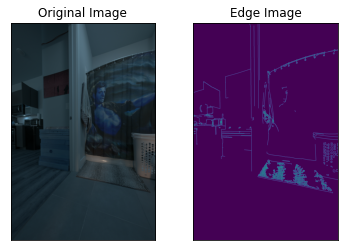

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
 
img = cv.imread('/Volumes/Research/3dgs-dataset/apartment/subset_1000/test/ours_30000/gt/00100.png',)
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv.Canny(img, 50, 150) / 255


plt.subplot(121),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges)
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
 
plt.show()

In [ ]:
size_quality_dict_100 = {}
input_dir = f"{root}/subset_filter_1000/per_view.json"
results = json.load(open(input_dir))
# read the SSIM, PSNR, LPIPS from the results
for key in results.keys():
    for metric in results[key].keys():
        size_quality_dict_100[metric] = []
        for png in results[key][metric].keys():
            eva_value = results[key][metric][png]
            size_quality_dict_100[metric].append(eva_value)

In [ ]:
# std of SSIM, PSNR, LPIPS
np.std(size_quality_dict_100['SSIM']), np.std(size_quality_dict_100['PSNR']), np.std(size_quality_dict_100['LPIPS'])

(0.04310731675211222, 4.030165020009551, 0.0377082296258062)

0.27692030644985705 0.27669457005187387


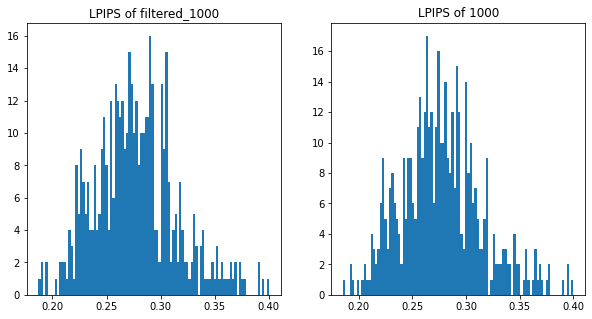

In [ ]:
# distribution of size_quality_dict_100['SSIM'] and size_quality_dict[1000]['SSIM']
metric = "LPIPS"
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].hist(size_quality_dict_100[metric], bins=100)
axs[0].set_title(f'{metric} of filtered_1000')
# axs[0].set_xlim(0.6, 1)
# axs[0].set_ylim(0, 40)

axs[1].hist(size_quality_dict[1000][metric], bins=100)
axs[1].set_title(f'{metric} of 1000')
# axs[1].set_xlim(0.6, 1)
# axs[1].set_ylim(0, 40)

print(np.mean(size_quality_dict_100[metric]), np.mean(size_quality_dict[1000][metric]))

### PSR

In [ ]:
def save_pcd(absolute_path, pcd):
    """
    save the point cloud data file (.ply).
    
    :param pcd: point cloud data file
    :param absolute_path: absolute path of point cloud data file
    """
    absolute_path = str(absolute_path)
    o3d.io.write_point_cloud(absolute_path, pcd, write_ascii=True)
    with open(absolute_path, 'r') as f:
        filedata = f.read()
        filedata = filedata.replace(' double', ' float')
    with open(absolute_path, 'w') as f:
        f.write(filedata)

def normal_estimation(ply_path, knn_k=100, RieGraph_k=20):
    ply_path = Path(ply_path)
    pcd = o3d.io.read_point_cloud(str(ply_path))
    # normal estimation
    KNN = o3d.geometry.KDTreeSearchParamKNN(knn=knn_k)
    pcd.estimate_normals(search_param=KNN, fast_normal_computation=True)
    pcd.orient_normals_consistent_tangent_plane(RieGraph_k)
    
    # save pcd with normals
    extension = str(ply_path.suffix)
    stem = str(ply_path.with_suffix(''))
    output_ply_path = Path(f'{stem}_norm{extension}')
    save_pcd(str(output_ply_path), pcd)

In [ ]:
# perform poisson surface reconstruction
import open3d as o3d

ply_path = "/Users/yuangshi/Documents/PhD/3DGS/denoising/points3D_norm.ply"
# Load saved point cloud and visualize it
pcd = o3d.io.read_point_cloud(ply_path)

# Perform poisson surface reconstruction
mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd, depth=9, width=0, scale=1.1, linear_fit=False)
o3d.io.write_triangle_mesh("/Users/yuangshi/Documents/PhD/3DGS/denoising/points3D_norm_mesh.ply", mesh)



True

: 

## Post-processing

### Position-guided-filter for 3DGS denoising

- https://github.com/aipiano/guided-filter-point-cloud-denoise
- Performance is very bad. Because only the position changed, the color and size is not changed. The position does look better.
  - Perhaps we can make it during the training process.

In [ ]:
def guided_filter(pcd, radius, epsilon):
    kdtree = o3d.geometry.KDTreeFlann(pcd)
    points_copy = np.array(pcd.points)
    points = np.asarray(pcd.points)
    num_points = len(pcd.points)

    for i in range(num_points):
        k, idx, _ = kdtree.search_radius_vector_3d(pcd.points[i], radius)
        if k < 3:
            continue

        neighbors = points[idx, :]
        mean = np.mean(neighbors, 0)
        cov = np.cov(neighbors.T)
        e = np.linalg.inv(cov + epsilon * np.eye(3))

        A = cov @ e
        b = mean - A @ mean

        points_copy[i] = A @ points[i] + b

    pcd.points = o3d.utility.Vector3dVector(points_copy)

def noise_removal(gs, radius, neigbor_num_threshold=3, dispersion_threshold=20):
    position = gs._xyz
    # select the points whose x, y, and z are in the 25% to 75% percentile
    x = position[:, 0]
    y = position[:, 1]
    z = position[:, 2]
    x_25, x_75 = np.percentile(x, 25), np.percentile(x, 75)
    y_25, y_75 = np.percentile(y, 25), np.percentile(y, 75)
    z_25, z_75 = np.percentile(z, 25), np.percentile(z, 75)

    opacity = gs._opacity.detach().cpu().numpy()
    opacity_25 = np.percentile(opacity, 60)
    
    scales = gs._scaling.detach().cpu().numpy()
    dispersion = np.array([scale @ scale.T for scale in scales])

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(position)

    kdtree = o3d.geometry.KDTreeFlann(pcd)
    points_copy = np.array(pcd.points)
    points = np.asarray(pcd.points)
    num_points = len(pcd.points)
    mask_point_indice = []

    for i in range(num_points):
        k, idx, _ = kdtree.search_radius_vector_3d(pcd.points[i], radius)
        # if the number of neighbors is less than neigbor_num_threshold, mask out the point
        # select the points whose x, y, and z are in the 25% to 75% percentile
        if k < neigbor_num_threshold and opacity[i] < opacity_25: # and dispersion[i] < dispersion_threshold and x_25 < x[i] < x_75 and y_25 < y[i] < y_75 and z_25 < z[i] < z_75 
            mask_point_indice.append(i)

    # # mask out the points that are not in the neighborhood, given the index of the points mask_point_indice
    # points_copy = np.delete(points_copy, mask_point_indice, axis=0)

    # pcd.points = o3d.utility.Vector3dVector(points_copy)
    # pcd.colors = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd.colors), mask_point_indice, axis=0))
    # pcd.normals = o3d.utility.Vector3dVector(np.delete(np.asarray(pcd.normals), mask_point_indice, axis=0))
    return mask_point_indice

In [ ]:
gs = GaussianModel(3)
gs.load_ply("/Users/yuangshi/Documents/PhD/3DGS/denoising/apartment_1000.ply")

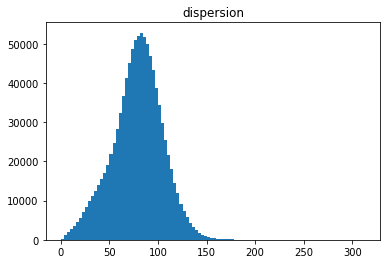

In [ ]:
# for each scale in the scales, get a list of scale times the transpose of the scale
scales = gs._scaling.detach().cpu().numpy()
dispersion = np.array([scale @ scale.T for scale in scales])

# get the distribution of the dispersion (a list of values)
fig = plt.hist(dispersion, bins=100)
plt.title('dispersion')
plt.show()

In [ ]:
opacity = gs._opacity
opacity = [item[0] for item in opacity]

np.percentile(gs._opacity, 0), np.percentile(gs._opacity, 25), np.percentile(gs._opacity, 50), np.percentile(gs._opacity, 60), np.percentile(gs._opacity, 75), np.percentile(gs._opacity, 100)

(-7.081196308135986,
 -3.5980820655822754,
 -1.0485879778862,
 0.356890428066253,
 3.4080735445022583,
 18.1163387298584)

In [ ]:
mask_point_indice = noise_removal(gs, radius=0.1, neigbor_num_threshold=25, dispersion_threshold=np.quantile(dispersion, 0.0001))

In [ ]:
gs._xyz = torch.tensor(np.delete(np.array(gs._xyz), mask_point_indice, axis=0), dtype=torch.float, device="cpu")
gs._normals = torch.tensor(np.delete(np.array(gs._normal), mask_point_indice, axis=0), dtype=torch.float, device="cpu")
gs._features_dc = torch.tensor(np.delete(np.array(gs._features_dc), mask_point_indice, axis=0), dtype=torch.float, device="cpu")
gs._features_rest = torch.tensor(np.delete(np.array(gs._features_rest), mask_point_indice, axis=0), dtype=torch.float, device="cpu")
gs._opacity = torch.tensor(np.delete(np.array(gs._opacity), mask_point_indice, axis=0), dtype=torch.float, device="cpu")
gs._scaling = torch.tensor(np.delete(np.array(gs._scaling), mask_point_indice, axis=0), dtype=torch.float, device="cpu")
gs._rotation = torch.tensor(np.delete(np.array(gs._rotation), mask_point_indice, axis=0), dtype=torch.float, device="cpu")

assert len(gs._xyz) == len(gs._features_dc) == len(gs._features_rest) == len(gs._opacity) == len(gs._scaling) == len(gs._rotation) == len(gs._normals)

In [ ]:
xyz = gs._xyz.detach().cpu().numpy()
normals = np.zeros_like(xyz)
f_dc = gs._features_dc.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
f_rest = gs._features_rest.detach().transpose(1, 2).flatten(start_dim=1).contiguous().cpu().numpy()
opacities = gs._opacity.detach().cpu().numpy()
scale = gs._scaling.detach().cpu().numpy()
rotation = gs._rotation.detach().cpu().numpy()

print(len(xyz), len(normals), len(f_dc), len(f_rest), len(opacities), len(scale), len(rotation))

932957 932957 932957 932957 932957 932957 932957


In [ ]:
path = "/Users/yuangshi/Documents/PhD/3DGS/denoising/apartment_1000_removed.ply"

dtype_full = [(attribute, 'f4') for attribute in gs.construct_list_of_attributes()]

elements = np.empty(xyz.shape[0], dtype=dtype_full)
attributes = np.concatenate((xyz, normals, f_dc, f_rest, opacities, scale, rotation), axis=1)
elements[:] = list(map(tuple, attributes))
el = PlyElement.describe(elements, 'vertex')
PlyData([el]).write(path)

# Multi-Resulution 3DGS

## Rescale the Dataset into Multiple Resolutions
- Downsample the images in dataset with different resolutions.

In [62]:
resolutions = [2,4,8] # 1/2, 1/4, 1/8
dataset_root = "/Volumes/Research/dataset/3DGS/source_dataset/db"
scene = "playroom"
raw_dataset_path = f"{dataset_root}/{scene}/images"

for resolution in resolutions:
    output_path = f"{dataset_root}/{scene}_res{resolution}/images"
    os.makedirs(output_path, exist_ok=True)
    print(f"Processing resolution {resolution}, output to {output_path}")
    for image in os.listdir(raw_dataset_path):
        if image.endswith("jpg") and not image.startswith("."):
            ori_img = cv2.imread(os.path.join(raw_dataset_path, image))
            down_img = cv2.resize(ori_img, (ori_img.shape[1]//resolution, ori_img.shape[0]//resolution))
            # up_img = cv2.resize(down_img, (ori_img.shape[1], ori_img.shape[0]))
            cv2.imwrite(os.path.join(output_path, image), down_img)
    
    # copy the folder sparse to the new folder
    os.system(f"cp -r {dataset_root}/{scene}/sparse {dataset_root}/{scene}_res{resolution}")

Processing resolution 2, output to /Volumes/Research/dataset/3DGS/source_dataset/db/playroom_res2/images
Processing resolution 4, output to /Volumes/Research/dataset/3DGS/source_dataset/db/playroom_res4/images
Processing resolution 8, output to /Volumes/Research/dataset/3DGS/source_dataset/db/playroom_res8/images


In [103]:
resolution_scales = [2,4,8] # 1/2, 1/4, 1/8
dataset_root = "/Volumes/Research/dataset/3DGS/source_dataset/nerf_synthetic"
splits = ["train","test"]
for split in splits:

    raw_dataset_path = f"{dataset_root}/lego/100/{split}/"
    json_transforms_path = f"{dataset_root}/lego/100/transforms_{split}.json"
    json_transforms = json.load(open(json_transforms_path))
    
    for resolution_scale in resolution_scales:
        output_path = f"{dataset_root}/lego/lego_res{resolution_scale}/{split}"
        os.makedirs(output_path, exist_ok=True)

        print(f"Processing resolution {resolution_scale}, output to {output_path}")

        # change the image resolution
        for image_path in os.listdir(raw_dataset_path):
            if image_path.endswith("png") and not image_path.startswith("."):

                # Opens a image in RGB mode 
                im = Image.open(os.path.join(raw_dataset_path, image_path)) 
                orig_width, orig_height = im.size 

                newsize = round(orig_width/(resolution_scale)), round(orig_height/(resolution_scale))

                im1 = im.resize(newsize)
                # # padding the image to the original size
                # im2 = Image.new("RGBA", (orig_width, orig_height), (0, 0, 0, 1))
                # im2.paste(im1, ((orig_width - im1.size[0]) // 2, (orig_height - im1.size[1]) // 2))
                im2 = im1.resize((orig_width, orig_height)) # resize to the original size
                
                # im1.save(os.path.join(output_path, image_path))
                im2.save(os.path.join(output_path, image_path))
        
        # change the camera position
        for idx, frame in enumerate(json_transforms["frames"]):
            transform_matrix = frame["transform_matrix"]
            for i in range(3):
                # transform_matrix[i][-1] = transform_matrix[i][-1] * resolution_scale
                transform_matrix[i][-1] = transform_matrix[i][-1] * 1
            frame["transform_matrix"] = transform_matrix
            json_transforms["frames"][idx] = frame
        
        with open(f"{dataset_root}/lego/lego_res{resolution_scale}/transforms_{split}.json", "w") as f:
            json.dump(json_transforms, f, indent=4)



Processing resolution 2, output to /Volumes/Research/dataset/3DGS/source_dataset/nerf_synthetic/lego/lego_res2/test
Processing resolution 4, output to /Volumes/Research/dataset/3DGS/source_dataset/nerf_synthetic/lego/lego_res4/test
Processing resolution 8, output to /Volumes/Research/dataset/3DGS/source_dataset/nerf_synthetic/lego/lego_res8/test


In [229]:
'''
Get the mean of SSIM, PSNR, LPIPS for each resolution
'''

scene = "lego"
root = f"/Volumes/Research/3dgs-models/{scene}/multiresolution"
methods = ["hierarchical","separate"] # "separate", "hierarchical"
downscale_method = "downscale" # "downscale_and_upscale" or "downscale"
resolutions = [1, 2, 4, 8]
size_quality_dict = {}

for method in methods:
    size_quality_dict[method] = {"SSIM": [], "PSNR": [], "LPIPS": [], "model_size": []}
    for resolution in resolutions:
        metrics_path = f"{root}/{method}/{downscale_method}/{scene}_res{resolution}/results.json"
        if method == "hierarchical":
            model_path = f"{root}/{method}/{downscale_method}/{scene}_res{resolution}/point_cloud/iteration_30000/point_cloud.ply"
        else:
            model_path = f"{root}/{method}/{downscale_method}/{scene}_res{resolution}/point_cloud/iteration_30000/point_cloud.ply"
        metrics = json.load(open(metrics_path))
        SSIM, PSNR, LPIPS = metrics["ours_30000"]["SSIM"], metrics["ours_30000"]["PSNR"], metrics["ours_30000"]["LPIPS"]
        model_size = os.path.getsize(model_path) / 1024 / 1024 # in MB
        size_quality_dict[method]["SSIM"].append(SSIM)
        size_quality_dict[method]["PSNR"].append(PSNR)
        size_quality_dict[method]["LPIPS"].append(LPIPS)
        size_quality_dict[method]["model_size"].append(model_size)

In [230]:
'''
Get the mean of 95% confidence interval of SSIM, PSNR, LPIPS for each resolution
'''

from scipy import stats

def split_list_into_n(my_list, n):
    # Calculate the size of each group
    group_size = len(my_list) // n
    remainder = len(my_list) % n

    # Split the list
    groups = []
    start = 0
    for i in range(n):
        end = start + group_size + (1 if i < remainder else 0)
        groups.append(my_list[start:end])
        start = end

    return groups

def calculate_ci_mean(group, confidence=0.95):
    n = len(group)
    mean = np.mean(group)
    se = stats.sem(group)
    ci = stats.t.interval(confidence, n-1, loc=mean, scale=se)
    ci_mean = np.mean(ci)
    return ci_mean

scene = "lego"
root = f"/Volumes/Research/3dgs-models/{scene}/multiresolution"
methods = ["hierarchical","separate"] # "separate", "hierarchical"
downscale_method = "downscale" # "downscale_and_upscale" or "downscale"
resolutions = [1, 2, 4, 8]
size_quality_dict = {}

for method in methods:
    size_quality_dict[method] = {"SSIM": [], "PSNR": [], "LPIPS": [], "model_size": []}
    for resolution in resolutions:
        metrics_path = f"{root}/{method}/{downscale_method}/{scene}_res{resolution}/per_view.json"
        if method == "hierarchical":
            model_path = f"{root}/{method}/{downscale_method}/{scene}_res{resolution}/point_cloud/iteration_30000/point_cloud.ply"
        else:
            model_path = f"{root}/{method}/{downscale_method}/{scene}_res{resolution}/point_cloud/iteration_30000/point_cloud.ply"
        metrics = json.load(open(metrics_path))
        model_size = os.path.getsize(model_path) / 1024 / 1024 # in MB
        size_quality_dict[method]["model_size"].append(model_size)

        for key in metrics.keys():
            for metric in metrics[key].keys():
                for png in metrics[key][metric].keys():
                    eva_value = metrics[key][metric][png]
                    size_quality_dict[method][metric].append(eva_value)
    
    for metric in metrics[key].keys():
        # split the list of size_quality_dict[method][metric] into len(resolutions) groups
        size_quality_dict[method][metric] = split_list_into_n(size_quality_dict[method][metric], len(resolutions))
        # for each group, calculate the mean of 95% confidence interval
        size_quality_dict[method][metric] = [calculate_ci_mean(group) for group in size_quality_dict[method][metric]]



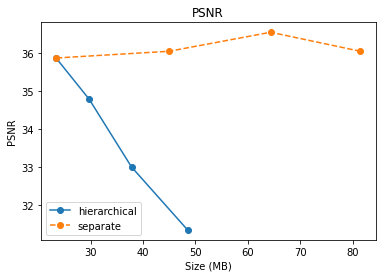

In [232]:
# plot the SSIM, PSNR, LPIPS against the dataset size
# for metric in ["SSIM", "PSNR", "LPIPS"]:
metric = "PSNR"
for method in methods:
    plt.plot(size_quality_dict[method]["model_size"], size_quality_dict[method][metric], marker='o', label=method, linestyle='--' if method == "separate" else None)
    plt.title(metric)
    plt.xlabel("Size (MB)")
    plt.ylabel(f"{metric}")
    if metric == "SSIM":
        plt.ylim(0.95, 1.0)
    # elif metric == "PSNR":
    #     plt.ylim(25, 32)
    # elif metric == "LPIPS":
    #     plt.ylim(0.24, 0.32)
    plt.legend()

In [233]:
gs_res8 = GaussianModel(3)
gs_res8.load_ply("/Volumes/Research/3dgs-models/lego/multiresolution/hierarchical/downscale/lego_res8/point_cloud/iteration_30000/point_cloud.ply")
gs_res8_size = gs_res8._xyz.shape[0]

position_res8 = gs_res8._xyz.detach().cpu().numpy()
features_dc_res8 = gs_res8._features_dc.detach().cpu().numpy()
features_rest_res8 = gs_res8._features_rest.detach().cpu().numpy()
opacity_res8 = gs_res8._opacity.detach().cpu().numpy()
scaling_res8 = gs_res8._scaling.detach().cpu().numpy()
rotation_res8 = gs_res8._rotation.detach().cpu().numpy()

gs_res4 = GaussianModel(3)
gs_res4.load_ply("/Volumes/Research/3dgs-models/lego/multiresolution/hierarchical/opacity/lego_res4/point_cloud/iteration_7000/point_cloud.ply")
gs_res4_size = gs_res4._xyz.shape[0]

position_res4 = gs_res4._xyz.detach().cpu().numpy()
features_dc_res4 = gs_res4._features_dc.detach().cpu().numpy()
features_rest_res4 = gs_res4._features_rest.detach().cpu().numpy()
opacity_res4 = gs_res4._opacity.detach().cpu().numpy()
scaling_res4 = gs_res4._scaling.detach().cpu().numpy()
rotation_res4 = gs_res4._rotation.detach().cpu().numpy()

In [235]:
opacity_res4[:1], opacity_res8[:1]

(array([[-4.59512]], dtype=float32), array([[2.7061594]], dtype=float32))

In [83]:
position_res4.shape, position_res4[(gs_res4_size-gs_res8_size):].shape, position_res8.shape

((205057, 3), (159867, 3), (159867, 3))

In [84]:
gs_added = GaussianModel(3)
gs_added._xyz = nn.Parameter(torch.tensor(position_res4[gs_res8_size:], dtype=torch.float, device="cpu"))
gs_added._features_dc = nn.Parameter(torch.tensor(features_dc_res4[gs_res8_size:], dtype=torch.float, device="cpu"))
gs_added._features_rest = nn.Parameter(torch.tensor(features_rest_res4[gs_res8_size:], dtype=torch.float, device="cpu"))
gs_added._opacity = nn.Parameter(torch.tensor(opacity_res4[gs_res8_size:], dtype=torch.float, device="cpu"))
gs_added._scaling = nn.Parameter(torch.tensor(scaling_res4[gs_res8_size:], dtype=torch.float, device="cpu"))
gs_added._rotation = nn.Parameter(torch.tensor(rotation_res4[gs_res8_size:], dtype=torch.float, device="cpu"))

gs_added.save_ply("/Volumes/Research/3dgs-models/lego/multiresolution/hierarchical/lego_res1/point_cloud/iteration_30000/point_cloud_added.ply")


In [101]:
'''
Color quantization with clustering
'''

import numpy as np
from sklearn.cluster import KMeans
from PIL import Image

def kmeans_color_quantization(image_path, k):
    # Load the image
    img = Image.open(image_path)
    img_array = np.array(img)

    # Reshape the image to be a list of pixels
    width, height, depth = img_array.shape
    pixels = img_array.reshape((width * height, depth))

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pixels)

    # Find the closest pixel to each cluster center
    centers = kmeans.cluster_centers_
    closest_pixels = np.zeros_like(centers, dtype=np.uint8)

    for i, center in enumerate(centers):
        cluster_pixels = pixels[kmeans.labels_ == i]
        closest_pixel = cluster_pixels[np.argmin(np.sum((cluster_pixels - center) ** 2, axis=1))]
        closest_pixels[i] = closest_pixel

    # Replace each pixel with its closest cluster representative
    quantized_pixels = closest_pixels[kmeans.labels_]

    # Reshape the image back to its original shape
    quantized_image = quantized_pixels.reshape((width, height, depth))

    # Convert back to PIL Image and save
    quantized_img = Image.fromarray(quantized_image)
    quantized_img.save(f'/Users/yuangshi/Downloads/quantized_{k}_colors_closest.png')

    print(f"Image quantized to {k} colors using closest pixels and saved as 'quantized_{k}_colors_closest.png'")

# Usage
image_path = '/Volumes/Research/dataset/3DGS/source_dataset/db/playroom/images/DSC05572.jpg'
number_of_colors = 5  # You can adjust this value

kmeans_color_quantization(image_path, number_of_colors)

/Users/yuangshi/.virtualenvs/vpcc/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Image quantized to 5 colors using closest pixels and saved as 'quantized_5_colors_closest.png'


## Results Analysis
- Set1: Render 3DGS into ds-x smaller images
- Set2: Render 3DGS into original size images

### SET1

In [ ]:
root = "/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene"
model_dir = f"{root}/M2-downsample_images"

dataset_resolution_list = [1, 2, 4, 8]
size_quality_dict = {}

for resolution in dataset_resolution_list:
    size_quality_dict[resolution] = {}
    if resolution == 1:
        input_dir = f"{root}/per_view_original.json"
        results = json.load(open(input_dir))
        model_path = f"{root}/drjohnson_original.ply"
    else:
        input_dir = f"{model_dir}/eva/image_with_ds_size/per_view_res_{resolution}.json"
        results = json.load(open(input_dir))
        model_path = f"{model_dir}/res_{resolution}_point_cloud.ply"
    # read the file size in MB
    size_quality_dict[resolution]['size'] = os.path.getsize(model_path) / 1024 / 1024
    # read the SSIM, PSNR, LPIPS from the results
    for key in results.keys():
        for metric in results[key].keys():
            size_quality_dict[resolution][metric] = []
            for png in results[key][metric].keys():
                eva_value = results[key][metric][png]
                size_quality_dict[resolution][metric].append(eva_value)

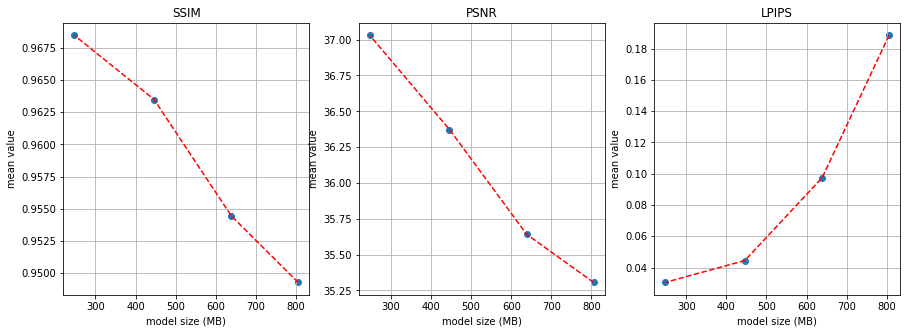

In [ ]:
# plot the mean SSIM, PSNR, LPIPS against the model size
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for metric, ax in zip(list(size_quality_dict[dataset_resolution_list[0]].keys())[1:], axs):
    if metric != "size":
        ax.scatter([size_quality_dict[size]['size'] for size in dataset_resolution_list], [np.mean(size_quality_dict[size][metric]) for size in dataset_resolution_list], marker='o')
        ax.set_title(metric)
        ax.set_xlabel("model size (MB)")
        ax.set_ylabel("mean value")
        ax.grid()
        # if metric == "SSIM":
        #     ax.set_ylim(0.87, 0.93)
        # elif metric == "PSNR":
        #     ax.set_ylim(25, 32)
        # elif metric == "LPIPS":
        #     ax.set_ylim(0.24, 0.32)
        
        
        # plot a fitted line based on the points, using polyfit with degree 2
        x = np.array([size_quality_dict[size]['size'] for size in dataset_resolution_list])
        y = np.array([np.mean(size_quality_dict[size][metric]) for size in dataset_resolution_list])
        z = np.polyfit(x, y, 3)
        p = np.poly1d(z)
        ax.plot(x, p(x), "r--")

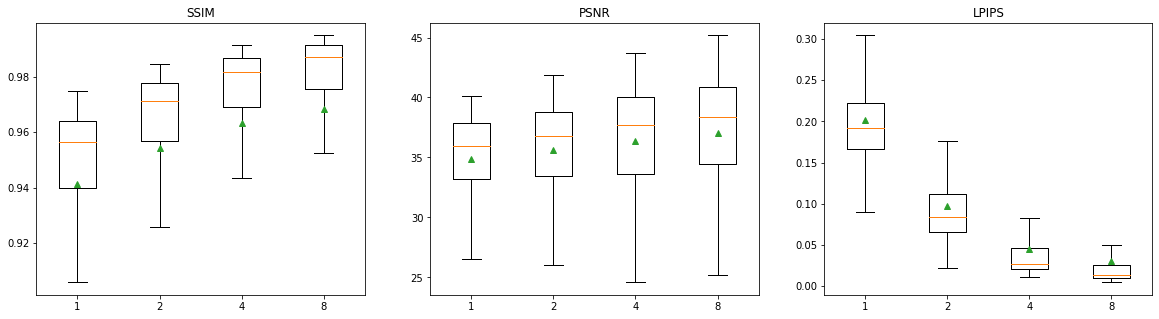

In [ ]:
# plot the SSIM, PSNR, LPIPS against the dataset size
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

dataset_size_list = list(size_quality_dict.keys())
ssim_list = [np.array(value['SSIM']).mean() for value in size_quality_dict.values()]
psnr_list = [np.array(value['PSNR']).mean() for value in size_quality_dict.values()]
lpips_list = [np.array(value['LPIPS']).mean() for value in size_quality_dict.values()]

# axs[0].plot(dataset_size_list, ssim_list, marker='o')
axs[0].boxplot([np.array(value['SSIM']) for value in size_quality_dict.values()], labels=dataset_size_list, showmeans=True, showfliers=False)
axs[0].set_title('SSIM')
# axs[0].set_ylim(0.87, 0.93)

# axs[1].plot(dataset_size_list, psnr_list, marker='o')
axs[1].boxplot([np.array(value['PSNR']) for value in size_quality_dict.values()], labels=dataset_size_list, showmeans=True, showfliers=False)
axs[1].set_title('PSNR')
# axs[1].set_ylim(25, 32)

# axs[2].plot(dataset_size_list, lpips_list, marker='o')
axs[2].boxplot([np.array(value['LPIPS']) for value in size_quality_dict.values()], labels=dataset_size_list, showmeans=True, showfliers=False)
axs[2].set_title('LPIPS')
# axs[2].set_xlim(0, 1450)
# axs[2].set_ylim(0.24, 0.32)


plt.show()

### SET2

In [ ]:
root = "/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene"
model_dir = f"{root}/M2-downsample_images"

dataset_resolution_list = [1, 2, 4, 8]
size_quality_dict = {}

for resolution in dataset_resolution_list:
    size_quality_dict[resolution] = {}
    if resolution == 1:
        input_dir = f"{root}/per_view_original.json"
        results = json.load(open(input_dir))
        model_path = f"{root}/drjohnson_original.ply"
    else:
        input_dir = f"{model_dir}/eva/image_with_original_size/per_view_res_{resolution}.json"
        results = json.load(open(input_dir))
        model_path = f"{model_dir}/res_{resolution}_point_cloud.ply"
    # read the file size in MB
    size_quality_dict[resolution]['size'] = os.path.getsize(model_path) / 1024 / 1024
    # read the SSIM, PSNR, LPIPS from the results
    for key in results.keys():
        for metric in results[key].keys():
            size_quality_dict[resolution][metric] = []
            for png in results[key][metric].keys():
                eva_value = results[key][metric][png]
                size_quality_dict[resolution][metric].append(eva_value)

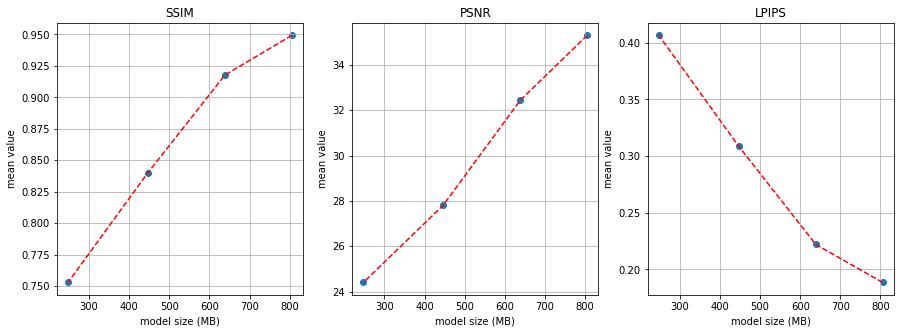

In [ ]:
# plot the mean SSIM, PSNR, LPIPS against the model size
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for metric, ax in zip(list(size_quality_dict[dataset_resolution_list[0]].keys())[1:], axs):
    if metric != "size":
        ax.scatter([size_quality_dict[size]['size'] for size in dataset_resolution_list], [np.mean(size_quality_dict[size][metric]) for size in dataset_resolution_list], marker='o')
        ax.set_title(metric)
        ax.set_xlabel("model size (MB)")
        ax.set_ylabel("mean value")
        ax.grid()
        # if metric == "SSIM":
        #     ax.set_ylim(0.87, 0.93)
        # elif metric == "PSNR":
        #     ax.set_ylim(25, 32)
        # elif metric == "LPIPS":
        #     ax.set_ylim(0.24, 0.32)
        
        
        # plot a fitted line based on the points, using polyfit with degree 2
        x = np.array([size_quality_dict[size]['size'] for size in dataset_resolution_list])
        y = np.array([np.mean(size_quality_dict[size][metric]) for size in dataset_resolution_list])
        z = np.polyfit(x, y, 3)
        p = np.poly1d(z)
        ax.plot(x, p(x), "r--")

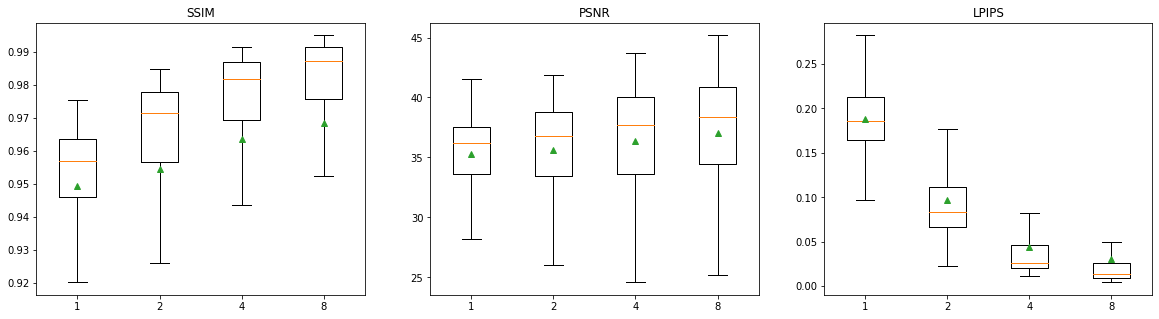

In [ ]:
# plot the SSIM, PSNR, LPIPS against the dataset size
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

dataset_size_list = list(size_quality_dict.keys())
ssim_list = [np.array(value['SSIM']).mean() for value in size_quality_dict.values()]
psnr_list = [np.array(value['PSNR']).mean() for value in size_quality_dict.values()]
lpips_list = [np.array(value['LPIPS']).mean() for value in size_quality_dict.values()]

# axs[0].plot(dataset_size_list, ssim_list, marker='o')
axs[0].boxplot([np.array(value['SSIM']) for value in size_quality_dict.values()], labels=dataset_size_list, showmeans=True, showfliers=False)
axs[0].set_title('SSIM')
# axs[0].set_ylim(0.87, 0.93)

# axs[1].plot(dataset_size_list, psnr_list, marker='o')
axs[1].boxplot([np.array(value['PSNR']) for value in size_quality_dict.values()], labels=dataset_size_list, showmeans=True, showfliers=False)
axs[1].set_title('PSNR')
# axs[1].set_ylim(25, 32)

# axs[2].plot(dataset_size_list, lpips_list, marker='o')
axs[2].boxplot([np.array(value['LPIPS']) for value in size_quality_dict.values()], labels=dataset_size_list, showmeans=True, showfliers=False)
axs[2].set_title('LPIPS')
# axs[2].set_xlim(0, 1450)
# axs[2].set_ylim(0.24, 0.32)


plt.show()

## Downsample the 3DGS Directly
- Calculate the significance score for each Gaussian
- Sort the Gaussians based on their scores
- Remove Gaussians whose scores are under a threshold (e.g., 90%)

### Naive Significance Score
- Only considering opacity and scaling
  - $S S^{(i)}=o^{(i)} \cdot\left(\frac{s_x^{(i)} \cdot s_y^{(i)} \cdot s_z^{(i)}}{S_{\max 90}}\right)^\beta$

In [77]:
def calculate_significance_score(gaussians, v_pow=0.1, o_pow=1):
    """
    :param gaussians: A data structure containing Gaussian components.
    :param v_pow: The power to which the volume ratios are raised. Set to 0.1 by default, as used in LightGaussian
    :return: A list of significance scores.
    """
    def power_negative(x, pow):
        return np.sign(x) * (np.abs(x)) ** (pow)
    
    # Calculate the ss of each Gaussian component
    ss_list = []
    volume_list = torch.prod(gaussians.get_scaling, dim=1).detach().cpu().numpy()
    volume_90percentile = np.percentile(volume_list, 90)
    opacity_list = gaussians.get_opacity.detach().cpu().numpy()
    
    for i in range(len(volume_list)):
        ss = (opacity_list[i][0] ** o_pow) * \
            ( (volume_list[i]/volume_90percentile) ** v_pow)
        ss_list.append(ss)
    
    return np.array(ss_list)

In [78]:
'''
Load 3DGS Scene
'''
scene = "lego"
# scene_path = "/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/drjohnson_original.ply"
scene_path = f"/Volumes/Research/dataset/3DGS/pre-trained_models/{scene}/point_cloud/iteration_30000/point_cloud.ply"

# read gaussians of a scene
gs = GaussianModel(sh_degree=3)
gs.load_ply(scene_path)

position = gs._xyz.detach().cpu().numpy()
features_dc = gs._features_dc.detach().cpu().numpy()
features_rest = gs._features_rest.detach().cpu().numpy()
opacity = gs._opacity.detach().cpu().numpy()
scaling = gs._scaling.detach().cpu().numpy()
rotation = gs._rotation.detach().cpu().numpy()

print(position.shape, features_dc.shape, features_rest.shape, opacity.shape, scaling.shape, rotation.shape)

(344439, 3) (344439, 1, 3) (344439, 15, 3) (344439, 1) (344439, 3) (344439, 4)


In [79]:
ss_list = calculate_significance_score(gs, o_pow=0)


In [80]:
Downsampling_Ratios = [1.1, 1.25, 2, 3, 4, 5, 6, 7, 8, 9, 10] # Each level contains ⌈C_num/DR⌉ of 3D Gaussians,

In [82]:
# sort the gaussians based on the significance score
sorted_indices = np.argsort(ss_list)[::-1]

for dr in Downsampling_Ratios[:4]:
    # ⌈C_num/dr⌉ of 3D Gaussians
    num_gaussians = int(len(ss_list) // dr)

    sorted_position = position[sorted_indices[:num_gaussians]]
    sorted_features_dc = features_dc[sorted_indices[:num_gaussians]]
    sorted_features_rest = features_rest[sorted_indices[:num_gaussians]]
    sorted_opacity = opacity[sorted_indices[:num_gaussians]]
    sorted_scaling = scaling[sorted_indices[:num_gaussians]]
    sorted_rotation = rotation[sorted_indices[:num_gaussians]]

    # save the sorted gaussians to a new ply file
    sorted_gs = GaussianModel(sh_degree=3)
    sorted_gs._xyz = nn.Parameter(torch.tensor(sorted_position, dtype=torch.float, device="cpu"))
    sorted_gs._features_dc = nn.Parameter(torch.tensor(sorted_features_dc, dtype=torch.float, device="cpu"))
    sorted_gs._features_rest = nn.Parameter(torch.tensor(sorted_features_rest, dtype=torch.float, device="cpu"))
    sorted_gs._opacity = nn.Parameter(torch.tensor(sorted_opacity, dtype=torch.float, device="cpu"))
    sorted_gs._scaling = nn.Parameter(torch.tensor(sorted_scaling, dtype=torch.float, device="cpu"))
    sorted_gs._rotation = nn.Parameter(torch.tensor(sorted_rotation, dtype=torch.float, device="cpu"))

    # sorted_gs.save_ply(f"/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/M1-downsample_3DGS/naive_ss/drjohnson_down_ratio_{dr}.ply")
    sorted_gs.save_ply(f"/Volumes/Research/dataset/3DGS/pre-trained_models/{scene}/point_cloud/iteration_30000/down_ratio_{dr}.ply")

    # save the removed gaussians to a new ply file
    removed_position = position[sorted_indices[num_gaussians:]]
    removed_features_dc = features_dc[sorted_indices[num_gaussians:]]
    removed_features_rest = features_rest[sorted_indices[num_gaussians:]]
    removed_opacity = opacity[sorted_indices[num_gaussians:]]
    removed_scaling = scaling[sorted_indices[num_gaussians:]]
    removed_rotation = rotation[sorted_indices[num_gaussians:]]

    removed_gs = GaussianModel(sh_degree=3)
    removed_gs._xyz = nn.Parameter(torch.tensor(removed_position, dtype=torch.float, device="cpu"))
    removed_gs._features_dc = nn.Parameter(torch.tensor(removed_features_dc, dtype=torch.float, device="cpu"))
    removed_gs._features_rest = nn.Parameter(torch.tensor(removed_features_rest, dtype=torch.float, device="cpu"))
    removed_gs._opacity = nn.Parameter(torch.tensor(removed_opacity, dtype=torch.float, device="cpu"))
    removed_gs._scaling = nn.Parameter(torch.tensor(removed_scaling, dtype=torch.float, device="cpu"))
    removed_gs._rotation = nn.Parameter(torch.tensor(removed_rotation, dtype=torch.float, device="cpu"))

    # removed_gs.save_ply(f"/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/M1-downsample_3DGS/naive_ss/drjohnson_removed_down_ratio_{dr}.ply")
    removed_gs.save_ply(f"/Volumes/Research/dataset/3DGS/pre-trained_models/{scene}/point_cloud/iteration_30000/removed_down_ratio_{dr}.ply")
    

#### Analyze the distribution of the removed and left splats

In [223]:
'''
Load 3DGS Scene
'''
scene = "playroom"
scene_path = f"/Volumes/Research/dataset/3DGS/pre-trained_models/{scene}/point_cloud/iteration_30000/removed_down_ratio_1.1.ply"
# scene_path = f"/Volumes/Research/dataset/3DGS/pre-trained_models/{scene}/point_cloud/iteration_30000/point_cloud.ply"

# read gaussians of a scene
gs = GaussianModel(sh_degree=3)
gs.load_ply(scene_path)

position = gs._xyz.detach().cpu().numpy()
features_dc = gs._features_dc.detach().cpu().numpy()
features_rest = gs._features_rest.detach().cpu().numpy()
opacity = gs._opacity.detach().cpu().numpy()
scaling = gs._scaling.detach().cpu().numpy()
rotation = gs._rotation.detach().cpu().numpy()

print(position.shape, features_dc.shape, features_rest.shape, opacity.shape, scaling.shape, rotation.shape)

(231466, 3) (231466, 1, 3) (231466, 15, 3) (231466, 1) (231466, 3) (231466, 4)


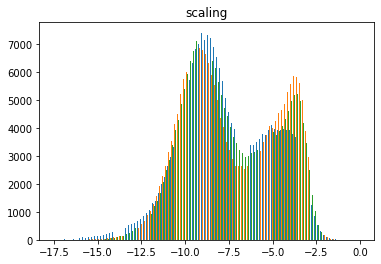

In [227]:
# plot the distribution of the scaling
fig = plt.hist(scaling, bins=100)
plt.title('scaling')
plt.show()

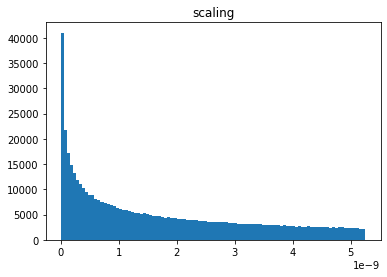

In [72]:
# plot the distribution of the scaling
fig = plt.hist(np.prod(np.exp(scaling), axis=1), bins=100)
plt.title('scaling')
plt.show()

#### Results Analysis

In [ ]:
root = "/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene"
model_dir = f"{root}/M1-downsample_3DGS"

downsample_ratios = list(range(1,11))
size_quality_dict = {}

for dr in downsample_ratios:
    size_quality_dict[dr] = {}
    if dr == 1:
        input_dir = f"{root}/per_view_original.json"
        results = json.load(open(input_dir))
        model_path = f"{root}/drjohnson_original.ply"
    else:
        input_dir = f"{model_dir}/eva/per_view_down_ratio_{dr}.json"
        results = json.load(open(input_dir))
        model_path = f"{model_dir}/drjohnson_down_ratio_{dr}.ply"
    # read the file size in MB
    size_quality_dict[dr]['size'] = os.path.getsize(model_path) / 1024 / 1024
    # read the SSIM, PSNR, LPIPS from the results
    for key in results.keys():
        for metric in results[key].keys():
            size_quality_dict[dr][metric] = []
            for png in results[key][metric].keys():
                eva_value = results[key][metric][png]
                size_quality_dict[dr][metric].append(eva_value)

In [ ]:
list(range(1,11))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

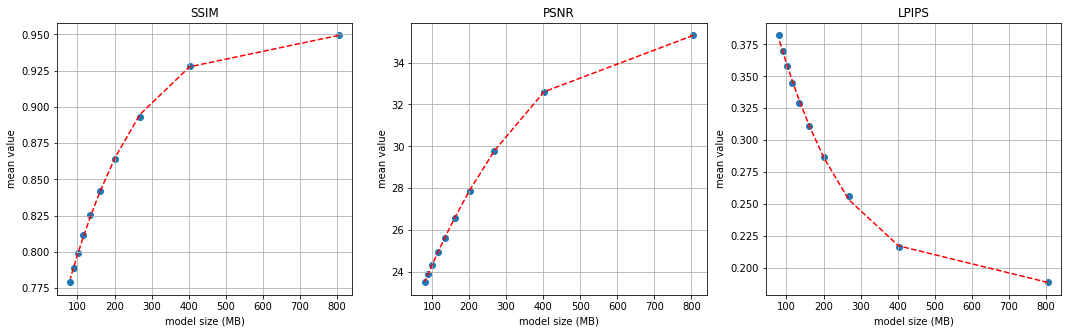

In [ ]:
# plot the mean SSIM, PSNR, LPIPS against the model size
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for metric, ax in zip(list(size_quality_dict[downsample_ratios[0]].keys())[1:], axs):
    if metric != "size":
        ax.scatter([size_quality_dict[dr]['size'] for dr in downsample_ratios], [np.mean(size_quality_dict[dr][metric]) for dr in downsample_ratios], marker='o')
        ax.set_title(metric)
        ax.set_xlabel("model size (MB)")
        ax.set_ylabel("mean value")
        ax.grid()
        # if metric == "SSIM":
        #     ax.set_ylim(0.87, 0.93)
        # elif metric == "PSNR":
        #     ax.set_ylim(25, 32)
        # elif metric == "LPIPS":
        #     ax.set_ylim(0.24, 0.32)
        
        
        # plot a fitted line based on the points, using polyfit with degree 2
        x = np.array([size_quality_dict[dr]['size'] for dr in downsample_ratios])
        y = np.array([np.mean(size_quality_dict[dr][metric]) for dr in downsample_ratios])
        z = np.polyfit(x, y, 3)
        p = np.poly1d(z)
        ax.plot(x, p(x), "r--")

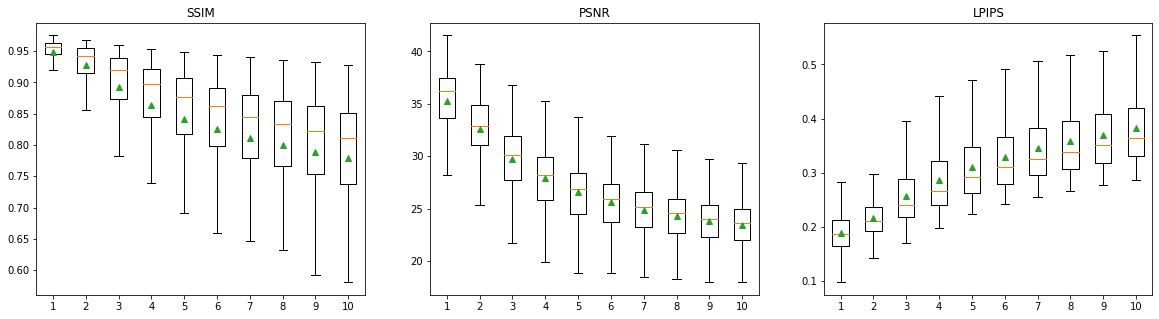

In [ ]:
# plot the SSIM, PSNR, LPIPS against the dataset size
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

dataset_size_list = list(size_quality_dict.keys())
ssim_list = [np.array(value['SSIM']).mean() for value in size_quality_dict.values()]
psnr_list = [np.array(value['PSNR']).mean() for value in size_quality_dict.values()]
lpips_list = [np.array(value['LPIPS']).mean() for value in size_quality_dict.values()]

# axs[0].plot(dataset_size_list, ssim_list, marker='o')
axs[0].boxplot([np.array(value['SSIM']) for value in size_quality_dict.values()], labels=dataset_size_list, showmeans=True, showfliers=False)
axs[0].set_title('SSIM')
# axs[0].set_ylim(0.87, 0.93)

# axs[1].plot(dataset_size_list, psnr_list, marker='o')
axs[1].boxplot([np.array(value['PSNR']) for value in size_quality_dict.values()], labels=dataset_size_list, showmeans=True, showfliers=False)
axs[1].set_title('PSNR')
# axs[1].set_ylim(25, 32)

# axs[2].plot(dataset_size_list, lpips_list, marker='o')
axs[2].boxplot([np.array(value['LPIPS']) for value in size_quality_dict.values()], labels=dataset_size_list, showmeans=True, showfliers=False)
axs[2].set_title('LPIPS')
# axs[2].set_xlim(0, 1450)
# axs[2].set_ylim(0.24, 0.32)


plt.show()

### Improved Significance Score
- We made an interesting observation: after downsampling (for both downsampling methods), the distortion always happens to the edges.
- $S S^{(i)}=o^{(i)} \cdot\left(\frac{s_x^{(i)} \cdot s_y^{(i)} \cdot s_z^{(i)}}{S_{\max } 90}\right)^\beta \cdot \frac{1}{\operatorname{Distance}(\mu, \operatorname{Line} 3 D++)}$
- Distance(.,.) measures the distance of each splat’s center point and its nearest line generated by Line3D++.

#### Processing

In [ ]:
'''
Generate line segments with Line3D++
'''

# 1. convert the colmap .bin output to .txt output
# # Command Line:
# python read_write_model.py --input_model path/to/model --input_format .bin --output_model path/to/output_model --output_format .txt


# 2. Use Line3D++ to process the colmap output
# # Command Line:
# ./runLine3Dpp_colmap -i path/to/imageAndColmapOutput

'\nGenerate line segments with Line3D++\n'

In [ ]:
'''
Calculate the distance of each splat to it's nearest line
'''

# 1. Load the Line3D++ output .txt file.

line3d_path = "/Volumes/Research/dataset/3DGS/source_dataset/db/drjohnson/images/Line3D++/Line3D++__W_FULL__N_10__sigmaP_2.5__sigmaA_10__epiOverlap_0.25__kNN_10__vis_3.txt"

with open(line3d_path, 'r') as f:
    lines = f.readlines()
    # for each line, read the 2nd to 7th values as the line direction, store them in the format of ((a,b,c),(d,e,f))
    line_vertices = np.array([
        [
            [float(line.split()[1]), float(line.split()[2]), float(line.split()[3])], 
            [float(line.split()[4]), float(line.split()[5]), float(line.split()[6])]
        ] 
        for line in lines])


In [ ]:
# 2. Load 3DGS Scene

scene_path = "/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/drjohnson_original.ply"

# read gaussians of a scene
gs = GaussianModel(sh_degree=3)
gs.load_ply(scene_path)


position = gs._xyz.detach().cpu().numpy()
features_dc = gs._features_dc.detach().cpu().numpy()
features_rest = gs._features_rest.detach().cpu().numpy()
opacity = gs._opacity.detach().cpu().numpy()
scaling = gs._scaling.detach().cpu().numpy()
rotation = gs._rotation.detach().cpu().numpy()

In [ ]:
def point_to_line_distance(point, line_start, line_end):
    """
    Calculate the minimum distance between a point and a line segment in 3D.

    Args:
    - point: A 3D point (numpy array).
    - line_start: Start point of the line segment (numpy array).
    - line_end: End point of the line segment (numpy array).

    Returns:
    - The distance between the point and the line segment.
    """
    # return np.linalg.norm( np.cross(line_end-line_start, line_start-point)) / np.linalg.norm(line_end-line_start)
    
    # https://stackoverflow.com/questions/54442057/calculate-the-euclidian-distance-between-an-array-of-points-to-a-line-segment-in/54442561#54442561
    d = np.divide(line_end - line_start, np.linalg.norm(line_end - line_start)) # normalized tangent vector
    
    s = np.dot(line_start - point, d) # signed parallel distance components
    t = np.dot(point - line_end, d) # signed parallel distance components

    h = np.maximum.reduce([s, t, 0]) # clamped parallel distance

    c = np.cross(point - line_start, d) # perpendicular distance component

    return np.hypot(h, np.linalg.norm(c))


# Flatten the line segments into points for KDTree
line_points = line_vertices.reshape(-1, 3)
kdtree = KDTree(line_points)

# Calculate the distance from each point to the nearest line
distances = []
for i, point in enumerate(gs.get_xyz.detach().cpu().numpy(), start=1):
    if i%100 == 0:
        print(f"Processing point {i}...")
    # Query the KD-Tree for the nearest k line segment points
    _, idx = kdtree.query(point, k=20)

    # Retrieve the corresponding line segments
    nearest_lines = line_vertices[idx // 2]

    # Calculate the distance to the nearest line segment
    min_distance = float('inf')
    for line in nearest_lines:
        line_start, line_end = line
        distance = point_to_line_distance(point, line_start, line_end)
        if distance < min_distance:
            min_distance = distance
    distances.append(min_distance)

# Convert distances to a numpy array for convenience
distances = np.array(distances)

# Save the distances to a .txt file 
np.savetxt("/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/drjohnson_original_distances_debugged.txt", distances)

Processing point 100...
Processing point 200...
Processing point 300...
Processing point 400...
Processing point 500...
Processing point 600...
Processing point 700...
Processing point 800...
Processing point 900...
Processing point 1000...
Processing point 1100...
Processing point 1200...
Processing point 1300...
Processing point 1400...
Processing point 1500...
Processing point 1600...
Processing point 1700...
Processing point 1800...
Processing point 1900...
Processing point 2000...
Processing point 2100...
Processing point 2200...
Processing point 2300...
Processing point 2400...
Processing point 2500...
Processing point 2600...
Processing point 2700...
Processing point 2800...
Processing point 2900...
Processing point 3000...
Processing point 3100...
Processing point 3200...
Processing point 3300...
Processing point 3400...
Processing point 3500...
Processing point 3600...
Processing point 3700...
Processing point 3800...
Processing point 3900...
Processing point 4000...
Processin

In [ ]:
def calculate_significance_score(gaussians, v_pow=0.1, d_pow=0.1, point_line_distance=None):
    """
    :param gaussians: A data structure containing Gaussian components.
    :param v_pow: The power to which the volume ratios are raised. Set to 0.1 by default, as used in LightGaussian
    :param line3d_vertices: A list of line vertices generated by Line3D++ algorithm.
    :return: A list of significance scores.
    """
        
    ss_list = []
    
    volume_list = torch.prod(gaussians.get_scaling, dim=1).detach().cpu().numpy()
    volume_90percentile = np.percentile(volume_list, 90)
    
    opacity_list = gaussians.get_opacity.detach().cpu().numpy()
    
    # distance_list = point_line_distance
    distance_list = ( point_line_distance / np.percentile(point_line_distance, 90) ) ** d_pow

    for i in range(len(volume_list)):
        ss = opacity_list[i][0] * \
            ( (volume_list[i]/volume_90percentile) ** v_pow ) * \
            distance_list[i]
        ss_list.append(ss)

    return np.array(ss_list)

In [ ]:
distance_path = "/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/drjohnson_original_distances_debugged.txt"
distances = np.loadtxt(distance_path)

In [ ]:
ss_list = calculate_significance_score(gaussians=gs, v_pow=0.1, d_pow=0.2, point_line_distance=distances)

In [ ]:
Downsampling_Ratios = [2, 3, 4, 5, 6, 7, 8, 9, 10] # Each level contains ⌈C_num/DR⌉ of 3D Gaussians,

In [ ]:
# sort the gaussians based on the significance score
sorted_indices = np.argsort(ss_list)[::-1]

for dr in Downsampling_Ratios:
    # ⌈C_num/dr⌉ of 3D Gaussians
    num_gaussians = len(ss_list) // dr

    sorted_position = position[sorted_indices[:num_gaussians]]
    sorted_features_dc = features_dc[sorted_indices[:num_gaussians]]
    sorted_features_rest = features_rest[sorted_indices[:num_gaussians]]
    sorted_opacity = opacity[sorted_indices[:num_gaussians]]
    sorted_scaling = scaling[sorted_indices[:num_gaussians]]
    sorted_rotation = rotation[sorted_indices[:num_gaussians]]

    # save the sorted gaussians to a new ply file
    sorted_gs = GaussianModel(sh_degree=3)
    sorted_gs._xyz = nn.Parameter(torch.tensor(sorted_position, dtype=torch.float, device="cpu"))
    sorted_gs._features_dc = nn.Parameter(torch.tensor(sorted_features_dc, dtype=torch.float, device="cpu"))
    sorted_gs._features_rest = nn.Parameter(torch.tensor(sorted_features_rest, dtype=torch.float, device="cpu"))
    sorted_gs._opacity = nn.Parameter(torch.tensor(sorted_opacity, dtype=torch.float, device="cpu"))
    sorted_gs._scaling = nn.Parameter(torch.tensor(sorted_scaling, dtype=torch.float, device="cpu"))
    sorted_gs._rotation = nn.Parameter(torch.tensor(sorted_rotation, dtype=torch.float, device="cpu"))

    sorted_gs.save_ply(f"/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/M1-downsample_3DGS/inverse_improved_ss/debugged_drjohnson_down_ratio_{dr}.ply")

#### Results Analysis

In [ ]:
downsample_method = "naive" # naive, improved, inverse_improved
root =  f"/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/M1-downsample_3DGS/{downsample_method}_ss"
eva_dir = f"/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/M1-downsample_3DGS/{downsample_method}_ss/eva"

image_resolutions = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
threedgs_resolutions = [2, 3, 4, 5, 6, 7, 8, 9, 10]
# threedgs_resolutions = [2, 3, 4, 5]

model_image_res_dict = {}
model_sizes = []
for threedgs_res in threedgs_resolutions:
    model_image_res_dict[threedgs_res] = {"PSNR":[],"SSIM":[],"LPIPS":[]}
    
    model_path = f"{root}/drjohnson_down_ratio_{threedgs_res}.ply"
    model_sizes.append(os.path.getsize(model_path) / 1024 / 1024)

    for image_res in image_resolutions:
        if downsample_method == "inverse_improved":
            ds_method = "improved"
        else:
            ds_method = downsample_method
        eva_path = f"{eva_dir}/results_dr_{ds_method}_model{threedgs_res}_image{image_res}.json"
        results = json.load(open(eva_path))
        for key in results.keys():
            for metric in results[key].keys():
                q = results[key][metric]
                model_image_res_dict[threedgs_res][metric].append(q)

In [ ]:
model_image_res_dict

{2: {'PSNR': [32.61820983886719,
   32.099937438964844,
   30.297595977783203,
   28.72205352783203,
   27.484548568725586,
   26.538028717041016,
   25.77960205078125,
   25.182432174682617,
   24.656923294067383,
   24.229881286621094],
  'SSIM': [0.9284460544586182,
   0.937506914138794,
   0.9201233386993408,
   0.8950241804122925,
   0.8685276508331299,
   0.8436449766159058,
   0.8207449316978455,
   0.8013407588005066,
   0.7829645872116089,
   0.7678396105766296],
  'LPIPS': [0.21599513292312622,
   0.11096897721290588,
   0.09148132801055908,
   0.09555558115243912,
   0.10665486752986908,
   0.11708953976631165,
   0.12879526615142822,
   0.13867618143558502,
   0.1437120884656906,
   0.1528163105249405]},
 3: {'PSNR': [29.76390838623047,
   29.269624710083008,
   28.19879913330078,
   27.029632568359375,
   26.006591796875,
   25.1774959564209,
   24.48607063293457,
   23.929174423217773,
   23.43274688720703,
   23.027029037475586],
  'SSIM': [0.8929940462112427,
   0.90038

In [ ]:
model_sizes.insert(0, 844.5)

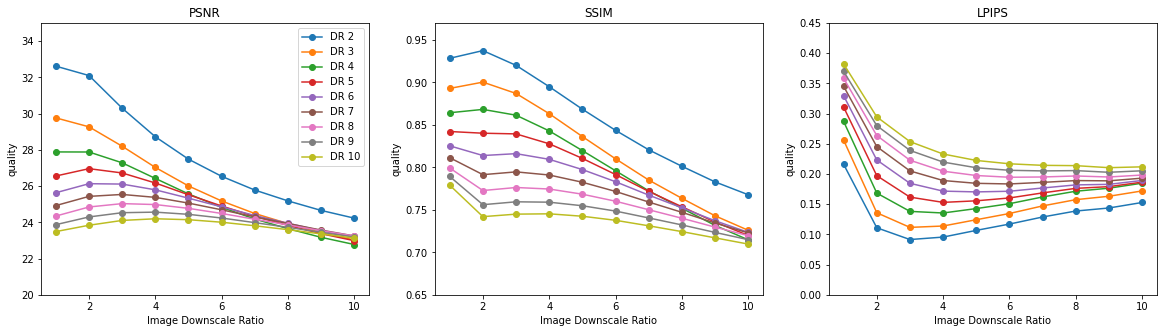

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for threedgs_res in threedgs_resolutions:
    for metric, ax in zip(list(model_image_res_dict[threedgs_res].keys()), axs):
        ax.grid()
        ax.plot(image_resolutions, model_image_res_dict[threedgs_res][metric], marker='o', label=f"DR {threedgs_res}")
        # ax.plot(model_sizes, model_image_res_dict[threedgs_res][metric], marker='o', label=f"DR {threedgs_res}")
        ax.set_title(metric)
        ax.set_xlabel("Image Downscale Ratio")
        ax.set_ylabel("quality")
        if metric == "SSIM":
            ax.set_ylim(0.65, 0.97)
        elif metric == "PSNR":
            ax.set_ylim(20, 35)
        elif metric == "LPIPS":
            ax.set_ylim(0, 0.45)

axs[0].legend()
axs[0].grid(); axs[1].grid(); axs[2].grid()

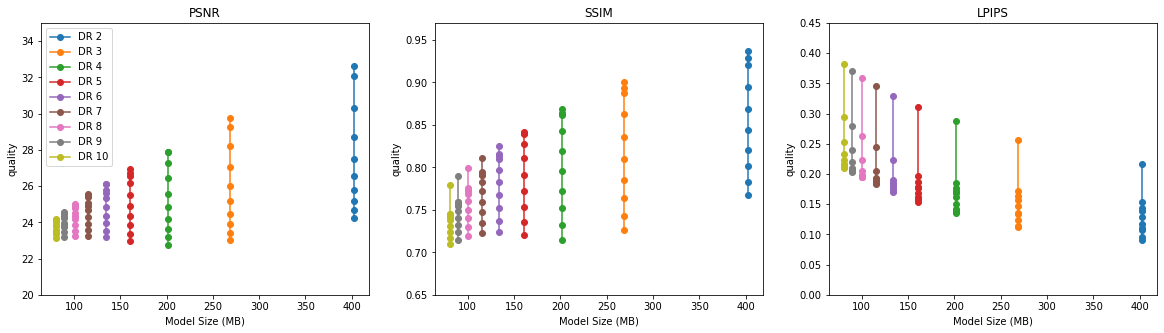

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for idx, threedgs_res in enumerate(threedgs_resolutions):
    for metric, ax in zip(list(model_image_res_dict[threedgs_res].keys()), axs):
        ax.grid()
        ax.plot(np.repeat(model_sizes[idx], 10), model_image_res_dict[threedgs_res][metric], marker='o', label=f"DR {threedgs_res}")
        ax.set_title(metric)
        ax.set_xlabel("Model Size (MB)")
        ax.set_ylabel("quality")
        if metric == "SSIM":
            ax.set_ylim(0.65, 0.97)
        elif metric == "PSNR":
            ax.set_ylim(20, 35)
        elif metric == "LPIPS":
            ax.set_ylim(0, 0.45)

axs[0].legend()
axs[0].grid(); axs[1].grid(); axs[2].grid()

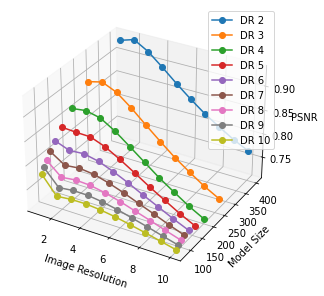

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')


for idx, threedgs_res in enumerate(threedgs_resolutions):
    ax.plot(image_resolutions, np.repeat(model_sizes[idx], 10),  model_image_res_dict[threedgs_res]['SSIM'], label=f"DR {threedgs_res}", marker='o')

ax.set_xlabel('Image Resolution')
ax.set_ylabel('Model Size')
ax.set_zlabel('PSNR')
ax.legend()

#### Debug

In [ ]:
'''
Check the difference between the wrong distances and the correct distances
'''
from scipy.stats.stats import pearsonr


# calculate correlation coefficient
wrong_distance_path = "/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/drjohnson_original_distances.txt"
wrong_distances = np.loadtxt(wrong_distance_path)

debugged_distance_path = "/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/drjohnson_original_distances_debugged.txt"
debugged_distances = np.loadtxt(debugged_distance_path)

print(pearsonr(wrong_distances, debugged_distances))

/var/folders/0g/bfr4kx9n70z_d0y7fvz7pgr80000gn/T/ipykernel_23082/378089595.py:4: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


PearsonRResult(statistic=0.8696285811626872, pvalue=0.0)


In [ ]:
threedgs_resolutions = [2, 3, 4, 5, 6, 7, 8, 9, 10]
position_cc_list = []

for resolution in threedgs_resolutions:
    wrong_3dgs_path = f"/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/M1-downsample_3DGS/naive_ss/drjohnson_down_ratio_{resolution}.ply"
    wrong_gs = GaussianModel(sh_degree=3)
    wrong_gs.load_ply(wrong_3dgs_path)

    debugged_3dgs_path = f"/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/M1-downsample_3DGS/inverse_improved_ss/debugged_drjohnson_down_ratio_{resolution}.ply"
    debugged_gs = GaussianModel(sh_degree=3)
    debugged_gs.load_ply(debugged_3dgs_path)

    wrong_position = wrong_gs._xyz.detach().cpu().numpy()
    debugged_position = debugged_gs._xyz.detach().cpu().numpy()
    
    position_cc = pearsonr(sorted(wrong_position.flatten()), sorted(debugged_position.flatten()))
    position_cc_list.append(position_cc[0])
    print(position_cc)

PearsonRResult(statistic=0.999993041970258, pvalue=0.0)
PearsonRResult(statistic=0.9999862411181559, pvalue=0.0)
PearsonRResult(statistic=0.9999615179324661, pvalue=0.0)
PearsonRResult(statistic=0.9998843443252576, pvalue=0.0)
PearsonRResult(statistic=0.999768371090201, pvalue=0.0)
PearsonRResult(statistic=0.9996454008202091, pvalue=0.0)
PearsonRResult(statistic=0.9995284831561106, pvalue=0.0)
PearsonRResult(statistic=0.9994280517494983, pvalue=0.0)
PearsonRResult(statistic=0.9993364156136173, pvalue=0.0)


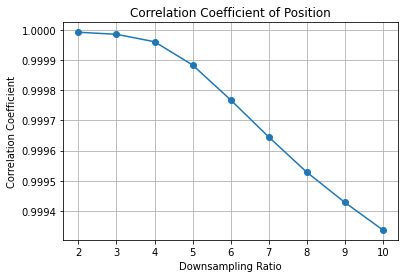

In [ ]:
# plot the correlation coefficient against the downsampling ratio
plt.plot(threedgs_resolutions, position_cc_list, marker='o')
plt.title("Correlation Coefficient of Position")
plt.xlabel("Downsampling Ratio")
plt.ylabel("Correlation Coefficient")
plt.grid()
plt.show()

### Remove Splats at the edge

In [96]:
gs_path = "/Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/point_cloud.ply"
gs = GaussianModel(sh_degree=3)
gs.load_ply(gs_path)
position = gs._xyz.detach().cpu().numpy()
features_dc = gs._features_dc.detach().cpu().numpy()
features_rest = gs._features_rest.detach().cpu().numpy()
opacity = gs._opacity.detach().cpu().numpy()
scaling = gs._scaling.detach().cpu().numpy()
rotation = gs._rotation.detach().cpu().numpy()

line3d_path = "/Volumes/Research/dataset/3DGS/source_dataset/db/playroom/sparse/0/Line3D++/Line3D++__W_FULL__N_10__sigmaP_2.5__sigmaA_10__epiOverlap_0.25__kNN_10__vis_3.txt"

line_vertices = read_line3d_from_txt(line3d_path)


In [101]:
# select lines whose length is bigger than the n percentile
n_percentile = 90
line_lengths = []
for line in line_vertices:
    line_lengths.append(np.linalg.norm(line[0] - line[1]))

line_lengths = np.array(line_lengths)
line_percentile = np.percentile(line_lengths, n_percentile)

selected_line_vertices = []
for line in line_vertices:
    if np.linalg.norm(line[0] - line[1]) > line_percentile:
        selected_line_vertices.append(line)

selected_line_vertices = np.array(selected_line_vertices)
selected_line_vertices.shape

(296, 2, 3)

In [102]:
# find the points in the range of the line segment, and the distance to the line segment is less than 0.1, record the index
line_point_indices_group = []
distance_threshold = 0.1
for line in selected_line_vertices:

    line_start = line[0]
    line_end = line[1]
    line_length = np.linalg.norm(line_end - line_start)
    line_direction = (line_end - line_start) / line_length

    # line_points = []
    line_point_indices = []
    for i, point in enumerate(position):
        projection = np.dot(point - line_start, line_direction)
        if projection < 0:
            projection = 0
        elif projection > line_length:
            projection = line_length
        closest_point = line_start + projection * line_direction
        distance = np.linalg.norm(point - closest_point)
        
        if distance < distance_threshold:
            # line_points.append(point)
            line_point_indices.append(i)

    # line_points = np.array(line_points)
    line_point_indices_group.append(np.array(list(set(line_point_indices))))

line_point_indices_group = np.array(list(set(np.concatenate(line_point_indices_group)))) # concatenate a list of arrays

In [103]:
# save the downsampled 3DGS
mask = np.ones(len(position), dtype=bool)
mask[line_point_indices_group.astype(int)] = False
new_position = position[mask]
new_features_dc = features_dc[mask]
new_features_rest = features_rest[mask]
new_opacity = opacity[mask]
new_scaling = scaling[mask]
new_rotation = rotation[mask]

new_gs = GaussianModel(sh_degree=3)
new_gs._xyz = nn.Parameter(torch.tensor(new_position, dtype=torch.float, device="cpu"))
new_gs._features_dc = nn.Parameter(torch.tensor(new_features_dc, dtype=torch.float, device="cpu"))
new_gs._features_rest = nn.Parameter(torch.tensor(new_features_rest, dtype=torch.float, device="cpu"))
new_gs._opacity = nn.Parameter(torch.tensor(new_opacity, dtype=torch.float, device="cpu"))
new_gs._scaling = nn.Parameter(torch.tensor(new_scaling, dtype=torch.float, device="cpu"))
new_gs._rotation = nn.Parameter(torch.tensor(new_rotation, dtype=torch.float, device="cpu"))

new_gs.save_ply(f"/Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/point_cloud_filtered_{n_percentile}.ply")


In [104]:
# save the removed 3DGS for visualization
removed_position = position[~mask]
removed_features_dc = features_dc[~mask]
removed_features_rest = features_rest[~mask]
removed_opacity = opacity[~mask]
removed_scaling = scaling[~mask]
removed_rotation = rotation[~mask]

removed_gs = GaussianModel(sh_degree=3)
removed_gs._xyz = nn.Parameter(torch.tensor(removed_position, dtype=torch.float, device="cpu"))
removed_gs._features_dc = nn.Parameter(torch.tensor(removed_features_dc, dtype=torch.float, device="cpu"))
removed_gs._features_rest = nn.Parameter(torch.tensor(removed_features_rest, dtype=torch.float, device="cpu"))
removed_gs._opacity = nn.Parameter(torch.tensor(removed_opacity, dtype=torch.float, device="cpu"))
removed_gs._scaling = nn.Parameter(torch.tensor(removed_scaling, dtype=torch.float, device="cpu"))
removed_gs._rotation = nn.Parameter(torch.tensor(removed_rotation, dtype=torch.float, device="cpu"))

removed_gs.save_ply(f"/Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/point_cloud_removed_{n_percentile}.ply")

: 

#### Encode Separately for Edge-Splats and Surface-Splats

##### Baseline (Encode/Decode the Whole Scene)

In [95]:
encoder_path = "/Users/yuangshi/Documents/PhD/3DGS/draco_adjusted-main/build_dir/draco_encoder"
gs_input_path = "/Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/point_cloud.ply"
qp = 6
data = {"qp": qp, 
        "qn": qp, 
        "qfd": qp, 
        "qfr1": qp, 
        "qfr2": qp, 
        "qfr3": qp, 
        "qo": qp, 
        "qs": qp, 
        "qr": qp, 
        "cl": 10}
draco_output_path = f"/Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/baseline/point_cloud_compressed_qp{data['qp']}.drc"

os.system(f'{encoder_path} -point_cloud \
            -i {gs_input_path} \
            -o {draco_output_path} \
            -qp {data["qp"]} -qn {data["qn"]} \
            -qfd {data["qfd"]} \
            -qfr1 {data["qfr1"]} -qfr2 {data["qfr2"]} -qfr3 {data["qfr3"]} \
            -qo {data["qo"]} \
            -qs {data["qs"]} -qr {data["qr"]} \
            -cl {data["cl"]}')

decoder_path = "/Users/yuangshi/Documents/PhD/3DGS/draco_adjusted-main/build_dir/draco_decoder"
decoded_output_path = f"/Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/baseline/point_cloud_decoded_qp{data['qp']}.ply"

os.system(f'{decoder_path} -point_cloud \
            -i {draco_output_path} \
            -o {decoded_output_path}')

Encoder options:
  Compression level = 10
  Positions: Quantization = 6 bits
  Normals: Quantization = 6 bits
  f_dc: Quantization = 6 bits
  f_rest_1: Quantization = 6 bits
  f_rest_2: Quantization = 6 bits
  f_rest_3: Quantization = 6 bits
  Opacity: Quantization = 6 bits
  Scale: Quantization = 6 bits
  Rotation: Quantization = 6 bits

[YC] kd_tree_possible
Encoded point cloud saved to /Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/draco/point_cloud_compressed_qp6.drc (1838 ms to encode).

Encoded size = 56893694 bytes

[YC] Encode
[YC] time: 1838
[YC] size: 56893694 bytes
[YC] num_points: 1734607
Decoded geometry saved to /Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/draco/point_cloud_decoded_qp6.ply (875 ms to decode)
[YC] Decode
[YC] time: 875


0

##### Our Method (Encode/Decode Separately)

In [ ]:
encoder_path = "/Users/yuangshi/Documents/PhD/3DGS/draco_adjusted-main/build_dir/draco_encoder"
decoder_path = "/Users/yuangshi/Documents/PhD/3DGS/draco_adjusted-main/build_dir/draco_decoder"

In [ ]:
qp = 10
data = {"qp": qp, 
        "qn": qp, 
        "qfd": qp, 
        "qfr1": qp, 
        "qfr2": qp, 
        "qfr3": qp, 
        "qo": qp, 
        "qs": qp, 
        "qr": qp, 
        "cl": 10}
removed_gs_input_path = "/Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/edge_aware/point_cloud_filtered_85/point_cloud_removed_85.ply"
removed_draco_output_path = f"/Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/edge_aware/point_cloud_filtered_85/point_cloud_removed_compressed_qp{data['qp']}.drc"
removed_decoded_output_path = f"/Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/edge_aware/point_cloud_filtered_85/point_cloud_removed_decoded_qp{data['qp']}.ply"


# Encode
os.system(f'{encoder_path} -point_cloud \
            -i {removed_gs_input_path} \
            -o {removed_draco_output_path} \
            -qp {data["qp"]} -qn {data["qn"]} \
            -qfd {data["qfd"]} \
            -qfr1 {data["qfr1"]} -qfr2 {data["qfr2"]} -qfr3 {data["qfr3"]} \
            -qo {data["qo"]} \
            -qs {data["qs"]} -qr {data["qr"]} \
            -cl {data["cl"]}')
# Decode
os.system(f'{decoder_path} -point_cloud \
            -i {removed_draco_output_path} \
            -o {removed_decoded_output_path}')

Encoder options:
  Compression level = 10
  Positions: Quantization = 10 bits
  Normals: Quantization = 10 bits
  f_dc: Quantization = 10 bits
  f_rest_1: Quantization = 10 bits
  f_rest_2: Quantization = 10 bits
  f_rest_3: Quantization = 10 bits
  Opacity: Quantization = 10 bits
  Scale: Quantization = 10 bits
  Rotation: Quantization = 10 bits

[YC] kd_tree_possible
Encoded point cloud saved to /Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/edge_aware/point_cloud_filtered_85/point_cloud_removed_compressed_qp10.drc (643 ms to encode).

Encoded size = 39948275 bytes

[YC] Encode
[YC] time: 643
[YC] size: 39948275 bytes
[YC] num_points: 607524
Decoded geometry saved to /Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/edge_aware/point_cloud_filtered_85/point_cloud_removed_decoded_qp10.ply (310 ms to decode)
[YC] Decode
[YC] time: 310


0

In [ ]:
qp = 16
data = {"qp": qp, 
        "qn": qp, 
        "qfd": qp, 
        "qfr1": qp, 
        "qfr2": qp, 
        "qfr3": qp, 
        "qo": qp, 
        "qs": qp, 
        "qr": qp, 
        "cl": 10}
filtered_gs_input_path = "/Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/edge_aware/point_cloud_filtered_85/point_cloud_filtered_85.ply"
filtered_draco_output_path = f"/Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/edge_aware/point_cloud_filtered_85/point_cloud_filtered_compressed_qp{data['qp']}.drc"
filtered_decoded_output_path = f"/Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/edge_aware/point_cloud_filtered_85/point_cloud_filtered_decoded_qp{data['qp']}.ply"


# Encode
os.system(f'{encoder_path} -point_cloud \
            -i {filtered_gs_input_path} \
            -o {filtered_draco_output_path} \
            -qp {data["qp"]} -qn {data["qn"]} \
            -qfd {data["qfd"]} \
            -qfr1 {data["qfr1"]} -qfr2 {data["qfr2"]} -qfr3 {data["qfr3"]} \
            -qo {data["qo"]} \
            -qs {data["qs"]} -qr {data["qr"]} \
            -cl {data["cl"]}')
# Decode
os.system(f'{decoder_path} -point_cloud \
            -i {filtered_draco_output_path} \
            -o {filtered_decoded_output_path}')

Encoder options:
  Compression level = 10
  Positions: Quantization = 16 bits
  Normals: Quantization = 16 bits
  f_dc: Quantization = 16 bits
  f_rest_1: Quantization = 16 bits
  f_rest_2: Quantization = 16 bits
  f_rest_3: Quantization = 16 bits
  Opacity: Quantization = 16 bits
  Scale: Quantization = 16 bits
  Rotation: Quantization = 16 bits

[YC] kd_tree_possible
Encoded point cloud saved to /Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/edge_aware/point_cloud_filtered_85/point_cloud_filtered_compressed_qp16.drc (1290 ms to encode).

Encoded size = 125245513 bytes

[YC] Encode
[YC] time: 1290
[YC] size: 125245513 bytes
[YC] num_points: 1127083
Decoded geometry saved to /Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/edge_aware/point_cloud_filtered_85/point_cloud_filtered_decoded_qp16.ply (574 ms to decode)
[YC] Decode
[YC] time: 574


0

In [ ]:
merged_gs_path = "/Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/edge_aware/point_cloud_filtered_85/point_cloud_decoded_merged_85.ply"

gs_merged = merge_two_3dgs(removed_decoded_output_path, filtered_decoded_output_path)
gs_merged.save_ply(merged_gs_path)

## Results Analysis (2 Methods Comparison)

In [26]:
downsample_method = "naive" # naive, improved, inverse_improved
root =  f"/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/M1-downsample_3DGS/{downsample_method}_ss"
eva_dir = f"/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/M1-downsample_3DGS/{downsample_method}_ss/eva"

image_resolutions = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
threedgs_resolutions = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# threedgs_resolutions = [2, 3, 4, 5]

model_image_res_dict = {}
model_sizes = []
for threedgs_res in threedgs_resolutions:
    model_image_res_dict[threedgs_res] = {"SSIM":[],"PSNR":[],"LPIPS":[]}
    if threedgs_res == 1:
        model_path = "/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/drjohnson_original.ply"
        model_sizes.append(os.path.getsize(model_path) / 1024 / 1024)
        for image_res in image_resolutions:
            eva_path = f"/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/renders_original/eva/results_original_image{image_res}.json"
            results = json.load(open(eva_path))
            for key in results.keys():
                for metric in results[key].keys():
                    q = results[key][metric]
                    model_image_res_dict[threedgs_res][metric].append(q)
    else:
        model_path = f"{root}/drjohnson_down_ratio_{threedgs_res}.ply"
        model_sizes.append(os.path.getsize(model_path) / 1024 / 1024)

        for image_res in image_resolutions:
            if downsample_method == "inverse_improved":
                ds_method = "improved"
            else:
                ds_method = downsample_method
            eva_path = f"{eva_dir}/results_dr_{ds_method}_model{threedgs_res}_image{image_res}.json"
            results = json.load(open(eva_path))
            for key in results.keys():
                for metric in results[key].keys():
                    q = results[key][metric]
                    model_image_res_dict[threedgs_res][metric].append(q)

In [27]:
model_image_res_dict

{1: {'SSIM': [0.9462587833404541,
   0.9478967785835266,
   0.9281080365180969,
   0.9027865529060364,
   0.8772783875465393,
   0.8540540337562561,
   0.8332735300064087,
   0.8160144090652466,
   0.7999047040939331,
   0.7867838740348816],
  'PSNR': [35.17238235473633,
   33.75395202636719,
   31.357704162597656,
   29.574382781982422,
   28.26900863647461,
   27.30550765991211,
   26.553009033203125,
   25.968435287475586,
   25.457618713378906,
   25.04821014404297],
  'LPIPS': [0.1925140917301178,
   0.10640814155340195,
   0.08977716416120529,
   0.09473865479230881,
   0.10631956160068512,
   0.1171189621090889,
   0.12893937528133392,
   0.1384798288345337,
   0.14369980990886688,
   0.15274900197982788]},
 2: {'SSIM': [0.9284460544586182,
   0.937506914138794,
   0.9201233386993408,
   0.8950241804122925,
   0.8685276508331299,
   0.8436449766159058,
   0.8207449316978455,
   0.8013407588005066,
   0.7829645872116089,
   0.7678396105766296],
  'PSNR': [32.61820983886719,
   32

In [28]:
root = "/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene"
model_dir = f"{root}/M2-downsample_images"

dataset_resolution_list = [1, 2, 4, 8]
size_quality_dict = {}

for resolution in dataset_resolution_list:
    size_quality_dict[resolution] = {}
    if resolution == 1:
        input_dir = f"{root}/per_view_original.json"
        results = json.load(open(input_dir))
        model_path = f"{root}/drjohnson_original.ply"
    else:
        input_dir = f"{model_dir}/eva/image_with_ds_size/per_view_res_{resolution}.json"
        results = json.load(open(input_dir))
        model_path = f"{model_dir}/res_{resolution}_point_cloud.ply"
    # read the file size in MB
    size_quality_dict[resolution]['size'] = os.path.getsize(model_path) / 1024 / 1024
    # read the SSIM, PSNR, LPIPS from the results
    for key in results.keys():
        for metric in results[key].keys():
            size_quality_dict[resolution][metric] = []
            for png in results[key][metric].keys():
                eva_value = results[key][metric][png]
                size_quality_dict[resolution][metric].append(eva_value)

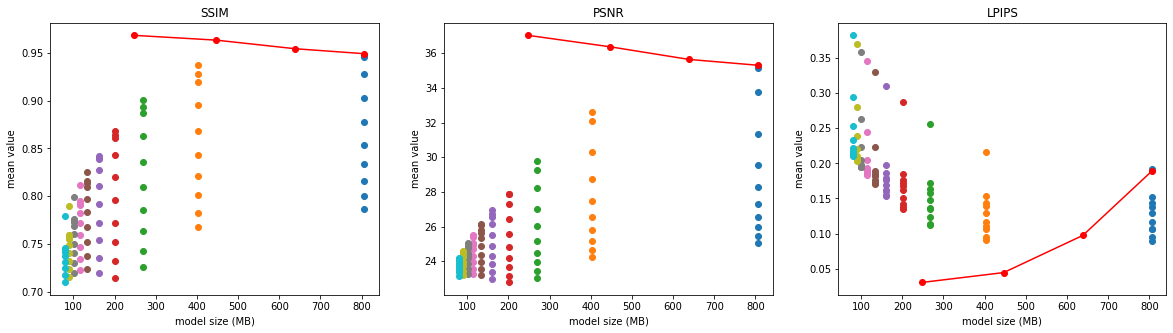

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

for idx, threedgs_res in enumerate(threedgs_resolutions):
    for metric, ax in zip(list(model_image_res_dict[threedgs_res].keys()), axs):
        ax.grid()
        ax.scatter(np.repeat(model_sizes[idx], 10), model_image_res_dict[threedgs_res][metric], marker='o', label=f"DR {threedgs_res}")
        ax.set_title(metric)
        ax.set_xlabel("Model Size (MB)")
        ax.set_ylabel("quality")
        # if metric == "SSIM":
        #     ax.set_ylim(0.65, 0.97)
        # elif metric == "PSNR":
        #     ax.set_ylim(20, 35)
        # elif metric == "LPIPS":
        #     ax.set_ylim(0, 0.45)

for metric, ax in zip(list(size_quality_dict[dataset_resolution_list[0]].keys())[1:], axs):
    if metric != "size":
        ax.plot([size_quality_dict[size]['size'] for size in dataset_resolution_list], [np.mean(size_quality_dict[size][metric]) for size in dataset_resolution_list], marker='o', label="Method 1", color='r')
        ax.set_title(metric)
        ax.set_xlabel("model size (MB)")
        ax.set_ylabel("mean value")
        ax.grid()


# axs[0].legend()
axs[0].grid(); axs[1].grid(); axs[2].grid()

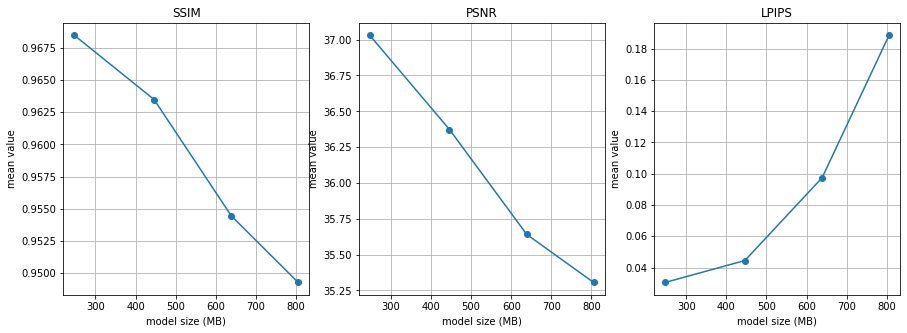

In [21]:
# plot the mean SSIM, PSNR, LPIPS against the model size
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

for metric, ax in zip(list(size_quality_dict[dataset_resolution_list[0]].keys())[1:], axs):
    if metric != "size":
        ax.plot([size_quality_dict[size]['size'] for size in dataset_resolution_list], [np.mean(size_quality_dict[size][metric]) for size in dataset_resolution_list], marker='o')
        ax.set_title(metric)
        ax.set_xlabel("model size (MB)")
        ax.set_ylabel("mean value")
        ax.grid()
        # if metric == "SSIM":
        #     ax.set_ylim(0.87, 0.93)
        # elif metric == "PSNR":
        #     ax.set_ylim(25, 32)
        # elif metric == "LPIPS":
        #     ax.set_ylim(0.24, 0.32)
        
        
        # # plot a fitted line based on the points, using polyfit with degree 2
        # x = np.array([size_quality_dict[size]['size'] for size in dataset_resolution_list])
        # y = np.array([np.mean(size_quality_dict[size][metric]) for size in dataset_resolution_list])
        # z = np.polyfit(x, y, 3)
        # p = np.poly1d(z)
        # ax.plot(x, p(x), "r--")

## Merge 3DGS
- https://repo-sam.inria.fr/fungraph/hierarchical-3d-gaussians/

### Utils

In [12]:
def read_line3d_from_txt(line3d_path):
    with open(line3d_path, 'r') as f:
        lines = f.readlines()
        # for each line, read the 2nd to 7th values as the line direction, store them in the format of ((a,b,c),(d,e,f))
        line_vertices = np.array([
            [
                [float(line.split()[1]), float(line.split()[2]), float(line.split()[3])], 
                [float(line.split()[4]), float(line.split()[5]), float(line.split()[6])]
            ] 
            for line in lines])
    return line_vertices

def point_to_line_distance(point, line_start, line_end):
    """
    Calculate the minimum distance between a point and a line segment in 3D.

    Args:
    - point: A 3D point (numpy array).
    - line_start: Start point of the line segment (numpy array).
    - line_end: End point of the line segment (numpy array).

    Returns:
    - The distance between the point and the line segment.
    """
    # return np.linalg.norm( np.cross(line_end-line_start, line_start-point)) / np.linalg.norm(line_end-line_start)
    
    # https://stackoverflow.com/questions/54442057/calculate-the-euclidian-distance-between-an-array-of-points-to-a-line-segment-in/54442561#54442561
    d = np.divide(line_end - line_start, np.linalg.norm(line_end - line_start)) # normalized tangent vector
    
    s = np.dot(line_start - point, d) # signed parallel distance components
    t = np.dot(point - line_end, d) # signed parallel distance components

    h = np.maximum.reduce([s, t, 0]) # clamped parallel distance

    c = np.cross(point - line_start, d) # perpendicular distance component

    return np.hypot(h, np.linalg.norm(c))


def merge_splats(mu_array, cov_array, weights=None):
    if weights is None:
        weights = np.ones(len(mu_array))
    mu_merge = np.average(mu_array, axis=0, weights=weights)

    cov_merge_array = [
        cov_array[i]
        + np.matmul((mu_array[i] - mu_merge), (mu_array[i] - mu_merge).T)
        for i in range(len(mu_array))
    ]
    cov_merge = np.average(np.array(cov_merge_array), axis=0, weights=weights)

    return mu_merge, cov_merge


# restore a symmetric covariance matrix, based on the upper triangular matrix
def restore_covariance(cov):
    cov_matrix = np.zeros((3,3))
    cov_matrix[np.triu_indices(3)] = cov
    cov_matrix[np.tril_indices(3, -1)] = cov_matrix.T[np.tril_indices(3, -1)]
    return cov_matrix

def get_cov_ellipsoid(cov, mu=np.zeros((3)), nstd=3):
    """
    Return the 3d points representing the covariance matrix
    cov centred at mu and scaled by the factor nstd.

    Plot on your favourite 3d axis. 
    Example 1:  ax.plot_wireframe(X,Y,Z,alpha=0.1)
    Example 2:  ax.plot_surface(X,Y,Z,alpha=0.1)
    """
    assert cov.shape==(3,3)

    # Find and sort eigenvalues to correspond to the covariance matrix
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.sum(cov,axis=0).argsort()
    eigvals_temp = eigvals[idx]
    idx = eigvals_temp.argsort()
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:,idx]

    # Set of all spherical angles to draw our ellipsoid
    n_points = 100
    theta = np.linspace(0, 2*np.pi, n_points)
    phi = np.linspace(0, np.pi, n_points)

    # Width, height and depth of ellipsoid
    rx, ry, rz = nstd * np.sqrt(eigvals)

    # Get the xyz points for plotting
    # Cartesian coordinates that correspond to the spherical angles:
    X = rx * np.outer(np.cos(theta), np.sin(phi))
    Y = ry * np.outer(np.sin(theta), np.sin(phi))
    Z = rz * np.outer(np.ones_like(theta), np.cos(phi))

    # Rotate ellipsoid for off axis alignment
    old_shape = X.shape
    # Flatten to vectorise rotation
    X,Y,Z = X.flatten(), Y.flatten(), Z.flatten()
    X,Y,Z = np.matmul(eigvecs, np.array([X,Y,Z]))
    X,Y,Z = X.reshape(old_shape), Y.reshape(old_shape), Z.reshape(old_shape)
   
    # Add in offsets for the mean
    X = X + mu[0]
    Y = Y + mu[1]
    Z = Z + mu[2]
    
    return X,Y,Z






### Testing Demo
- find the longest line
- find points around the line
- merge the points

In [4]:
'''
1. find groups of gaussians which are close to the lines
2. merge each group of gaussians into N gaussians
3. save the merged gaussians to a new ply file
'''


'\n1. find groups of gaussians which are close to the lines\n2. merge each group of gaussians into N gaussians\n3. save the merged gaussians to a new ply file\n'

In [13]:
gs_path = "/Volumes/Research/dataset/3DGS/pre-trained_models/playroom/point_cloud/iteration_7000/point_cloud.ply"
gs = GaussianModel(sh_degree=3)
gs.load_ply(gs_path)
position = gs._xyz.detach().cpu().numpy()
# features_dc = gs._features_dc.detach().cpu().numpy()
# features_rest = gs._features_rest.detach().cpu().numpy()
# opacity = gs._opacity.detach().cpu().numpy()
# scaling = gs._scaling.detach().cpu().numpy()
# rotation = gs._rotation.detach().cpu().numpy()

line3d_path = "/Volumes/Research/dataset/3DGS/source_dataset/db/playroom/sparse/0/Line3D++/Line3D++__W_FULL__N_10__sigmaP_2.5__sigmaA_10__epiOverlap_0.25__kNN_10__vis_3.txt"

line_vertices = read_line3d_from_txt(line3d_path)


In [14]:
# find the longest line
line_lengths = []
for line in line_vertices:
    line_lengths.append(np.linalg.norm(line[0] - line[1]))
longest_line_idx = np.argmax(line_lengths)
longest_line = line_vertices[longest_line_idx]
longest_line

array([[ 4.8508  ,  2.55332 ,  2.77083 ],
       [ 4.76353 , -3.34021 ,  0.197469]])

In [15]:
line_start = longest_line[0]
line_end = longest_line[1]
line_length = np.linalg.norm(line_end - line_start)
line_direction = (line_end - line_start) / line_length

# find the points in the range of the line segment, and the distance to the line segment is less than 0.1, record the index
line_points = []
line_point_indices = []
for i, point in enumerate(position):
    projection = np.dot(point - line_start, line_direction)
    if projection < 0:
        projection = 0
    elif projection > line_length:
        projection = line_length
    closest_point = line_start + projection * line_direction
    distance = np.linalg.norm(point - closest_point)
    if distance < 0.1:
        line_points.append(point)
        line_point_indices.append(i)

line_points = np.array(line_points)
line_point_indices = np.array(line_point_indices)
line_points.shape

(7560, 3)

In [16]:
# draw the line and the points using open3d
import open3d as o3d

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(line_points)

line = o3d.geometry.LineSet()
line.points = o3d.utility.Vector3dVector([longest_line[0], longest_line[1]])
line.lines = o3d.utility.Vector2iVector([[0, 1]])

o3d.visualization.draw_geometries([pcd, line])


[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


2024-06-21 14:44:38.288 Python[7465:1578284] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.
2024-06-21 14:44:48.123 Python[7465:1578284] TSM AdjustCapsLockLEDForKeyTransitionHandling - _ISSetPhysicalKeyboardCapsLockLED Inhibit


In [17]:
cluster_size = len(mu_array)

mu_array = gs._xyz.detach().cpu().numpy()[line_point_indices]
cov_array = np.array([restore_covariance(cov) for cov in gs.get_covariance()[line_point_indices]])

# sort the gaussians based on the mu_array into n clusters, and merge the gaussians in each cluster
sorted_indices = np.argsort(mu_array[:,0])
n = len(mu_array)
merged_mu_array = []
merged_cov_array = []
merged_weights = []
for i in range(0, n, cluster_size):
    mu_cluster = mu_array[sorted_indices][i:i+cluster_size]
    cov_cluster = cov_array[sorted_indices][i:i+cluster_size]
    mu_merge, cov_merge = merge_splats(mu_cluster, cov_cluster)
    merged_mu_array.append(mu_merge)
    merged_cov_array.append(cov_merge)

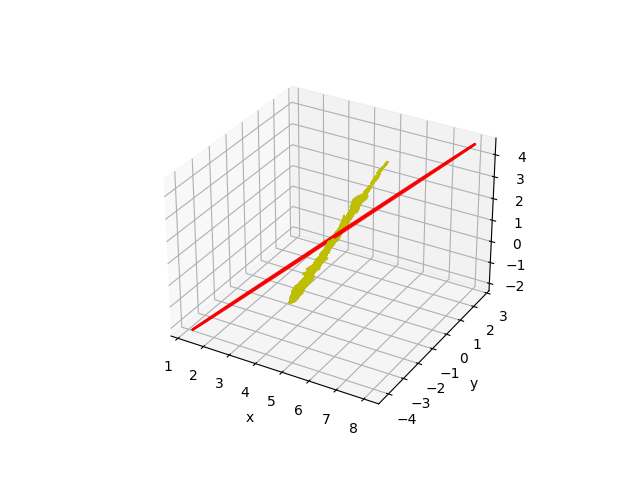

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Setup the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.xlabel('x')
plt.ylabel('y')

for i in range(len(mu_array[:2000])):
    mu = mu_array[sorted_indices[i]]
    cov = cov_array[sorted_indices[i]]
    s = np.random.multivariate_normal(mu, cov, (200))

    nstd = 2
    mu_ = np.mean(s, axis=0)
    cov_ = np.cov(s.T)
    X1,Y1,Z1 = get_cov_ellipsoid(cov_, mu_, nstd)
    ax.plot_wireframe(X1,Y1,Z1, color='y', alpha=0.1)

for i in range(len(merged_mu_array))[:1]:
    mu_merge = merged_mu_array[i]
    cov_merge = merged_cov_array[i]
    
    mu = mu_merge
    cov = cov_merge
    s = np.random.multivariate_normal(mu, cov, (200))

    nstd = 2
    mu_ = np.mean(s, axis=0)
    cov_ = np.cov(s.T)
    X1,Y1,Z1 = get_cov_ellipsoid(cov_, mu_, nstd)
    ax.plot_wireframe(X1,Y1,Z1, color='r', alpha=0.1)

plt.show()

In [18]:
debugged_3dgs_path = "/Users/yuangshi/Documents/PhD/3DGS/ds_pre-trained_scene/M1-downsample_3DGS/naive_ss/drjohnson_down_ratio_10.ply"
debugged_gs = GaussianModel(sh_degree=3)
debugged_gs.load_ply(debugged_3dgs_path)

In [43]:
r0, s0, mu0, cov0 = debugged_gs._rotation[0], debugged_gs.get_scaling[0], debugged_gs.get_xyz[0], debugged_gs.get_covariance()[0]
r1, s1, mu1, cov1 = debugged_gs._rotation[1], debugged_gs.get_scaling[1], debugged_gs.get_xyz[1], debugged_gs.get_covariance()[1]
r3, s3, mu3 = (debugged_gs._rotation[0:1] + debugged_gs._rotation[1:2]) / 2, (debugged_gs.get_scaling[0:1] + debugged_gs.get_scaling[1:2]) / 2, (debugged_gs.get_xyz[0:1] + debugged_gs.get_xyz[1:2]) / 2
cov3 = debugged_gs.build_covariance_from_scaling_rotation(s3, 1, r3)
print(r0, s0, torch.log(s0), mu0, "\n", cov0, "\n", restore_covariance(cov0))
print(r1, s1, torch.log(s1), mu1, "\n", cov1, "\n", restore_covariance(cov1))

tensor([ 1.2015,  0.0081, -0.2976, -0.1078]) tensor([0.3606, 0.5456, 0.4369]) tensor([-1.0200, -0.6058, -0.8281]) tensor([0.9559, 3.2990, 0.4142]) 
 tensor([ 0.1477,  0.0264, -0.0235,  0.2927,  0.0105,  0.1782]) 
 [[ 0.14768155  0.0263688  -0.02351091]
 [ 0.0263688   0.29273084  0.01051   ]
 [-0.02351091  0.01051     0.17818812]]
tensor([ 0.7544,  0.1492, -0.6264,  0.1286]) tensor([0.5006, 0.5429, 0.2699]) tensor([-0.6920, -0.6108, -1.3096]) tensor([6.2127, 1.3279, 3.7187]) 
 tensor([ 0.1110, -0.0777,  0.0265,  0.2617,  0.0143,  0.2456]) 
 [[ 0.11095844 -0.07772227  0.0264668 ]
 [-0.07772227  0.26170155  0.01434294]
 [ 0.0264668   0.01434294  0.24558212]]


In [45]:
cov = restore_covariance(cov0)
eigvals, eigvecs = np.linalg.eigh(cov) 
# idx = np.sum(cov,axis=0).argsort()
# eigvals_temp = eigvals[idx]
# idx = eigvals_temp.argsort()
# eigvals = eigvals[idx]
# eigvecs = eigvecs[:,idx]

eigvals, debugged_gs.get_scaling[0], debugged_gs._scaling[0], eigvecs

(array([0.1300207 , 0.19086347, 0.29771633]),
 tensor([0.3606, 0.5456, 0.4369]),
 tensor([-1.0200, -0.6058, -0.8281]),
 array([[ 0.87023458,  0.46432769,  0.16459515],
        [-0.1708758 , -0.02886482,  0.98486968],
        [ 0.46205327, -0.88519298,  0.0542232 ]]))

In [125]:
# get quaternion from eigvecs
def rotation2quat(R):
    trace = R[0, 0] + R[1, 1] + R[2, 2] + 1.0
    s = 0.5 / np.sqrt(trace)
    x = (R[1, 2] - R[2, 1]) * s
    y = (R[2, 0] - R[0, 2]) * s
    z = (R[0, 1] - R[1, 0]) * s
    w = 0.25 / s
    return np.array([w, x, y, z])

q = rotation2quat(eigvecs)
# normalize the quaternion
n_q = q / np.linalg.norm(q)
n_q

# self.scaling_activation = torch.exp

array([ 0.98495564, -0.04154401, -0.00113721,  0.16773547])